In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import skew
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,fbeta_score,roc_auc_score,matthews_corrcoef
from imblearn.metrics import geometric_mean_score
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv("Kaggle_Company_Bankruptcy_Prediction.csv")

In [3]:
df.isna().sum()

Bankrupt                                                    0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [4]:
df.duplicated().sum()

0

In [5]:
df.shape

(6819, 96)

In [6]:
df[' Net Income Flag'].value_counts()

1    6819
Name:  Net Income Flag, dtype: int64

In [7]:
df = df.drop([' Net Income Flag'],axis=1) #단일값 변수 우선 삭제 

Class Count 
 0    6599
1     220
Name: Bankrupt, dtype: int64 

Stable 96.77 % of the dataset
Unstable 3.23 % of the dataset


<AxesSubplot:title={'center':'Class Distributions \n (0: Not Bankrupt || 1: Bankrupt)'}, xlabel='Bankrupt', ylabel='count'>

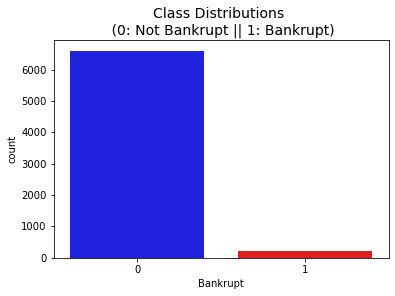

In [8]:
# 클래스 비율 
print('Class Count','\n',df['Bankrupt'].value_counts(),'\n')
print('Stable', round(df['Bankrupt'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Unstable', round(df['Bankrupt'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
plt.title('Class Distributions \n (0: Not Bankrupt || 1: Bankrupt)', fontsize=14)
colors = ["blue", "red"]
sns.countplot(df['Bankrupt'],palette=colors)

In [9]:
#df.info()

In [10]:
df[' Liability-Assets Flag'].value_counts()

0    6811
1       8
Name:  Liability-Assets Flag, dtype: int64

In [11]:
df.groupby('Bankrupt')[' Liability-Assets Flag'].value_counts() #변수 선택법에서 유용하지 않음 

Bankrupt   Liability-Assets Flag
0         0                         6597
          1                            2
1         0                          214
          1                            6
Name:  Liability-Assets Flag, dtype: int64

In [12]:
df = df.drop([' Liability-Assets Flag'],axis=1,inplace=False)

### Feature Selection 

#####  Lasso Penalty(L1) --> 로지스틱 회귀에 접합하기 위한 데이터 사전에 표준화 

In [13]:
X = df.drop(['Bankrupt'],axis=1,inplace=False)
y = df['Bankrupt']

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_data = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled_data,y,test_size=0.3,random_state=2021,stratify=y)

In [16]:
#param = {'C': [10**-2,10**-1,10**0,10**1,10**2]} # Best C : 0.1 

param = {'C': [0.1]}
lr_model = LogisticRegression(penalty='l1', solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
gs_model.fit(X_train, y_train)

# Train a LR model with best parameters
model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [17]:
coef = model.coef_[0]
red_features = pd.Series(X.columns)[list(coef==0)]
imp_features = pd.Series(X.columns)[list(coef!=0)]

In [18]:
print('Important Features Count:',sum(coef!=0))
print('Important Features Name:',list(imp_features))

Important Features Count: 34
Important Features Name: [' ROA(C) before interest and depreciation before interest', ' ROA(B) before interest and depreciation after tax', ' Pre-tax net Interest Rate', ' Operating Expense Rate', ' Net Value Per Share (B)', ' Persistent EPS in the Last Four Seasons', ' Regular Net Profit Growth Rate', ' Total Asset Growth Rate', ' Cash Reinvestment %', ' Quick Ratio', ' Total debt/Total net worth', ' Debt ratio %', ' Net worth/Assets', ' Borrowing dependency', ' Inventory and accounts receivable/Net value', ' Total Asset Turnover', ' Accounts Receivable Turnover', ' Fixed Assets Turnover Frequency', ' Net Worth Turnover Rate (times)', ' Revenue per person', ' Operating profit per person', ' Cash/Total Assets', ' Cash/Current Liability', ' Current Liability to Assets', ' Inventory/Working Capital', ' Working Capital/Equity', ' Total expense/Assets', ' Quick Asset Turnover Rate', ' Cash Turnover Rate', ' Fixed Assets to Assets', ' Net Income to Total Assets'

In [19]:
print('Redundant Features Count:',sum(coef==0))
#print('Redundant Features Name:',list(red_features))

Redundant Features Count: 59


In [20]:
data_df = df.drop(df[red_features],axis=1,inplace=False)

In [21]:
# Selected Features 
X = data_df.drop(['Bankrupt'],axis=1,inplace=False)
y = data_df['Bankrupt']

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=2021,stratify=y)

### 시각화 & 요약통계량 --> 34개 변수 

In [23]:
pd.set_option('display.max_columns', None)
data_df.groupby('Bankrupt').describe()

ROA(C) before interest and depreciation before interest            \
                                                            count      mean   
Bankrupt                                                                      
0                                                    6599.0        0.508069   
1                                                     220.0        0.418503   

                                                                      \
               std       min       25%       50%       75%       max   
Bankrupt                                                               
0         0.057694  0.000000  0.478623  0.504314  0.537074  1.000000   
1         0.081068  0.024277  0.391703  0.441330  0.469276  0.576951   

          ROA(B) before interest and depreciation after tax            \
                                                      count      mean   
Bankrupt                                                                
0                                                    6599.0  0.556659   
1                                                     220.0  0.461483   

                                                                      \
               std       min       25%       50%       75%       max   
Bankrupt                                                               
0         0.057864  0.000000  0.529472  0.553563  0.585577  1.000000   
1         0.091825  0.033514  0.432665  0.488597  0.519153  0.619091   

          Pre-tax net Interest Rate                                         \
                              count     mean       std       min       25%   
Bankrupt                                                                     
0                            6599.0  0.79721  0.013068  0.000000  0.797392   
1                             220.0  0.79659  0.003177  0.757216  0.796831   

                                        Operating Expense Rate                \
               50%       75%       max                   count          mean   
Bankrupt                                                                       
0         0.797468  0.797583  1.000000                  6599.0  1.998943e+09   
1         0.797156  0.797338  0.797761                   220.0  1.887486e+09   

                                                                    \
                   std       min       25%       50%           75%   
Bankrupt                                                             
0         3.237204e+09  0.000000  0.000157  0.000276  4.155000e+09   
1         3.257616e+09  0.000102  0.000163  0.000335  2.932500e+09   

                        Net Value Per Share (B)                                \
                   max                    count      mean       std       min   
Bankrupt                                                                        
0         9.990000e+09                   6599.0  0.191669  0.033272  0.000000   
1         9.890000e+09                    220.0  0.160416  0.020187  0.069656   

                                                  \
               25%       50%       75%       max   
Bankrupt                                           
0         0.174329  0.185074  0.200329  1.000000   
1         0.148140  0.158021  0.174339  0.218659   

          Persistent EPS in the Last Four Seasons                      \
                                            count      mean       std   
Bankrupt                                                                
0                                          6599.0  0.230146  0.032510   
1                                           220.0  0.188818  0.030709   

                                                            \
               min       25%       50%       75%       max   
Bankrupt                                                     
0         0.078567  0.215278  0.225111  0.239671  1.000000   
1         0.000000  0.176397  0.195944  0.208944  0.252529   

          Regular Net Profit Growth Rat

In [24]:
correlation_matrix = data_df.corr()
correlation_matrix.style.background_gradient(sns.light_palette('blue', as_cmap= True))

,Bankrupt,ROA(C) before interest and depreciation before interest,ROA(B) before interest and depreciation after tax,Pre-tax net Interest Rate,Operating Expense Rate,Net Value Per Share (B),Persistent EPS in the Last Four Seasons,Regular Net Profit Growth Rate,Total Asset Growth Rate,Cash Reinvestment %,Quick Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Borrowing dependency,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Cash/Total Assets,Cash/Current Liability,Current Liability to Assets,Inventory/Working Capital,Working Capital/Equity,Total expense/Assets,Quick Asset Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Degree of Financial Leverage (DFL)
Bankrupt,1.000000,-0.260807,-0.273051,-0.008517,-0.006083,-0.165399,-0.219560,-0.036820,-0.044431,-0.051345,0.025058,0.012314,0.250161,-0.250161,0.176543,0.075278,-0.067915,-0.004754,0.072818,0.021089,0.039718,-0.092842,-0.100130,0.077921,0.194494,-0.001906,-0.147221,0.139049,0.025814,-0.018035,0.066328,-0.315457,0.035104,-0.005547,0.010508
ROA(C) before interest and depreciation before interest,-0.260807,1.000000,0.986849,0.053419,0.066869,0.505580,0.775006,0.115040,0.019635,0.296158,-0.026336,-0.022208,-0.261427,0.261427,-0.161671,-0.109888,0.210622,-0.033947,-0.065919,0.022896,-0.014834,0.301996,0.235314,-0.046009,-0.210256,-0.004447,0.103819,-0.296019,-0.027280,-0.029477,-0.009192,0.887670,-0.071725,0.008135,-0.016575
ROA(B) before interest and depreciation after tax,-0.273051,0.986849,1.000000,0.053726,0.065602,0.502052,0.764597,0.117042,0.022104,0.292008,-0.024232,-0.021161,-0.264734,0.264734,-0.158618,-0.109501,0.194810,-0.033768,-0.061046,0.012763,-0.014545,0.304522,0.227144,-0.041296,-0.217186,-0.001616,0.101962,-0.322223,-0.029928,-0.030410,-0.008364,0.912040,-0.089088,0.007523,-0.014663
Pre-tax net Interest Rate,-0.008517,0.053419,0.053726,1.000000,0.014247,0.033034,0.033726,0.034914,0.037633,0.017801,-0.017376,-0.001964,-0.003906,0.003906,-0.004654,0.009042,0.029667,0.089576,0.003581,0.015513,-0.144956,0.020271,0.017136,-0.001404,0.001632,0.010231,0.014933,-0.004525,0.012206,0.015581,-0.000047,0.048587,-0.004243,-0.000075,0.000855
Operating Expense Rate,-0.006083,0.066869,0.065602,0.014247,1.000000,0.090519,0.080969,0.009511,0.014168,-0.003016,0.017687,-0.016164,0.143833,-0.143833,0.023977,0.079747,0.195063,-0.028331,-0.055160,0.165135,-0.010492,0.126869,-0.110605,0.024258,0.135256,-0.008018,0.007324,-0.249426,0.153936,0.040730,-0.007464,0.071365,-0.025524,0.006497,0.013577
Net Value Per Share (B),-0.165399,0.505580,0.502052,0.033034,0.090519,1.000000,0.755568,0.056518,-0.018871,0.090651,-0.002909,0.008546,-0.249146,0.249146,-0.123991,-0.089396,0.082026,-0.018647,-0.080971,-0.032829,-0.017799,0.261330,0.185621,-0.033078,-0.198546,-0.005685,0.070112,-0.235573,-0.043038,-0.054775,-0.003112,0.493776,-0.059970,0.014303,-0.021860
Persistent EPS in the Last Four Seasons,-0.219560,0.775006,0.764597,0.033726,0.080969,0.755568,1.000000,0.086083,-0.036743,0.165224,-0.004244,-0.011383,-0.177429,0.177429,-0.144138,-0.037986,0.214710,-0.019997,-0.129457,0.066033,-0.011412,0.351589,0.240956,-0.034404,-0.097689,0.000283,0.121854,-0.177996,-0.029352,-0.034256,-0.006477,0.691152,-0.033509,0.003791,-0.018829
Regular Net Profit Growth Rate,-0.036820,0.115040,0.117042,0.034914,0.009511,0.056518,0.086083,1.000000,0.008911,0.019473,0.000783,0.000524,-0.030512,0.030512,-0.012109,-0.005827,0.060223,-0.019103,-0.004697,0.035224,-0.128905,0.046101,0.020039,-0.005428,-0.022080,0.001776,0.004243,-0.032827,0.014146,0.013462,0.000376,0.119870,0.001166,0.002026,0.002014
Total Asset Growth Rate,-0.044431,0.019635,0.022104,0.037633,0.014168,-0.018871,-0.036743,0.008911,1.000000,0.063710,-0.013451,-0.012469,-0.049191,0.049191,-0.019354,-0.045200,-0.0723

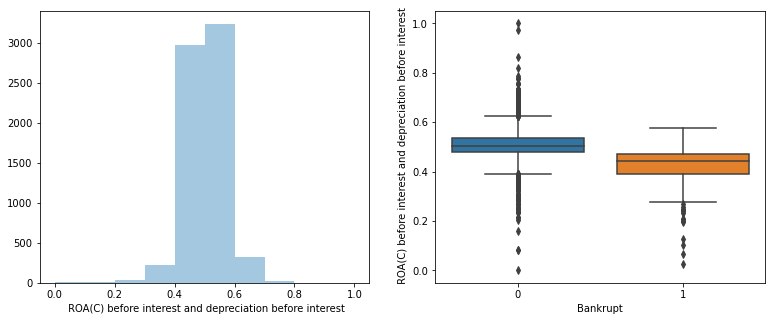

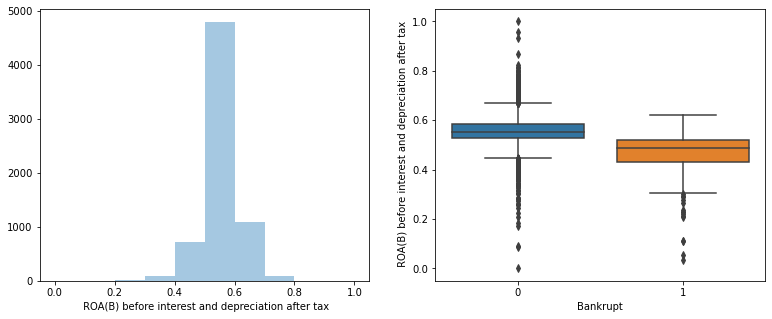

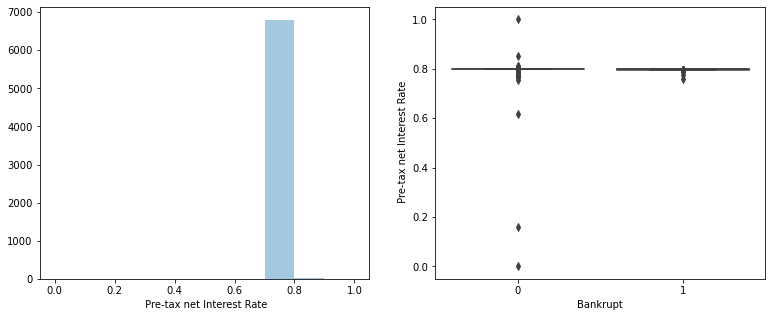

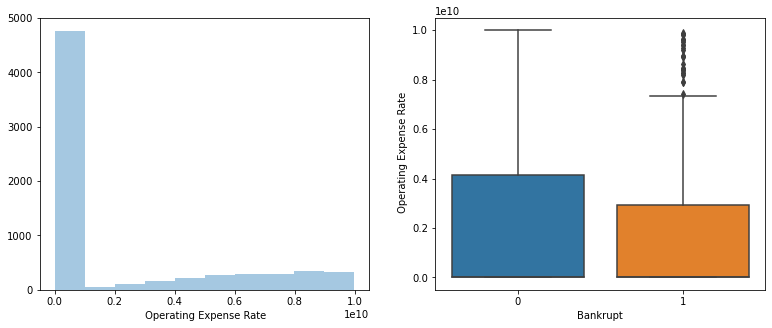

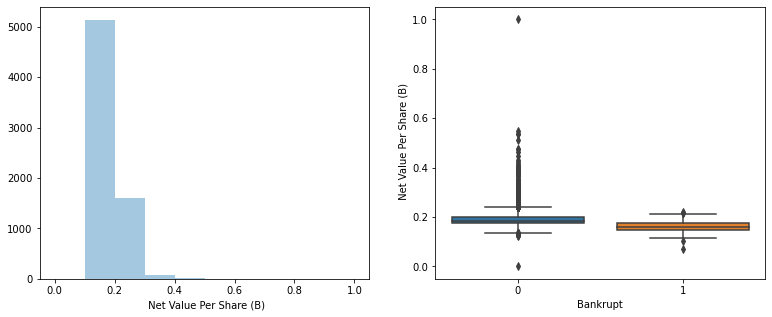

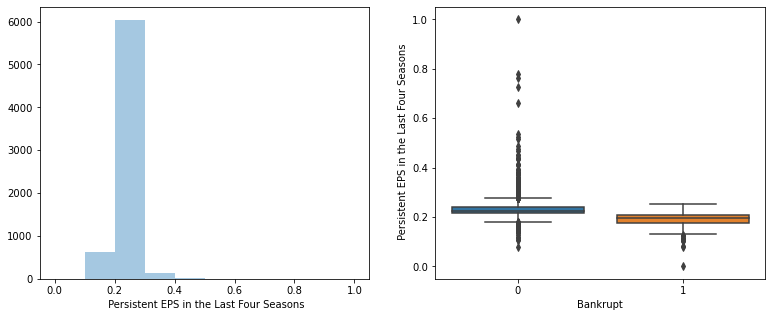

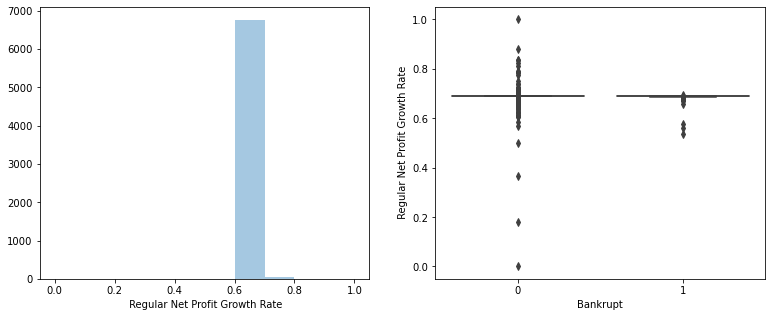

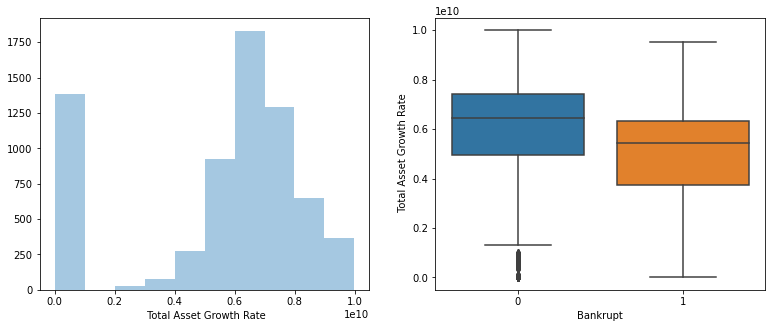

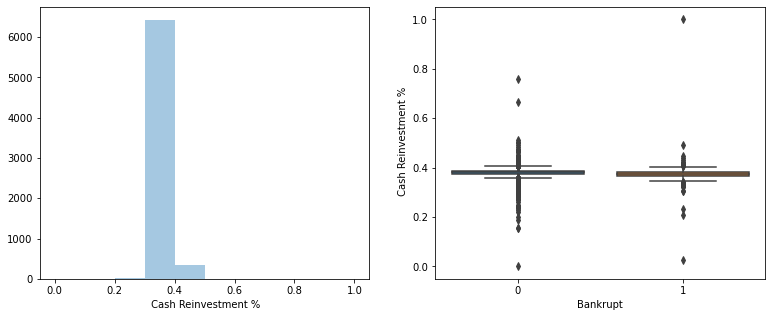

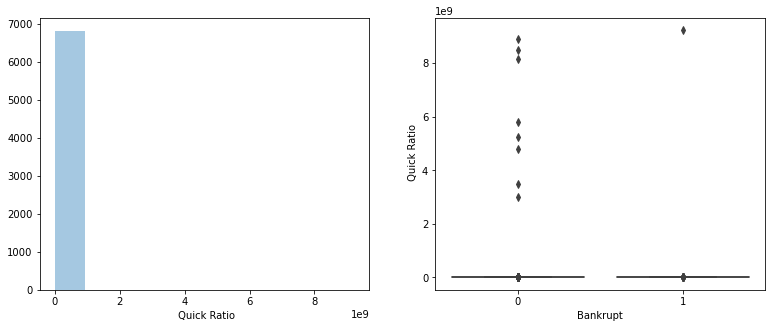

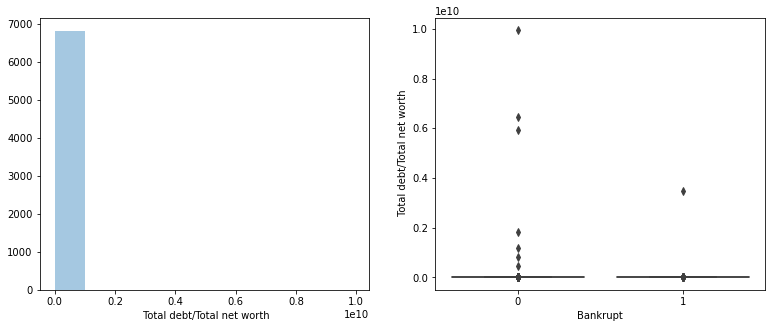

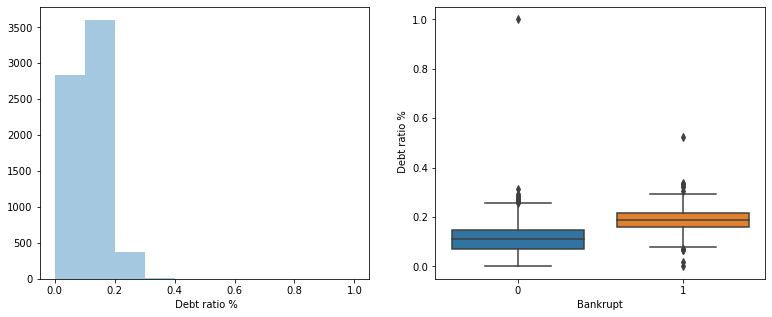

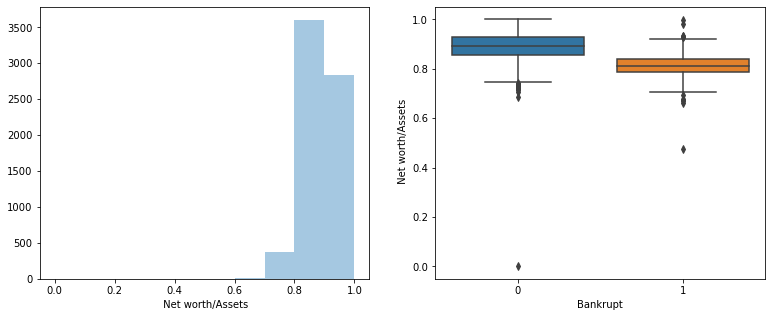

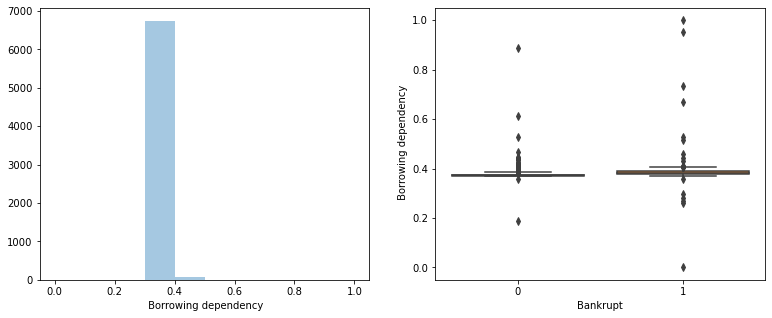

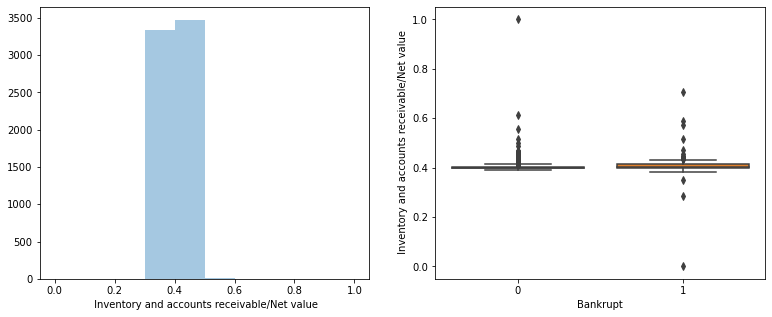

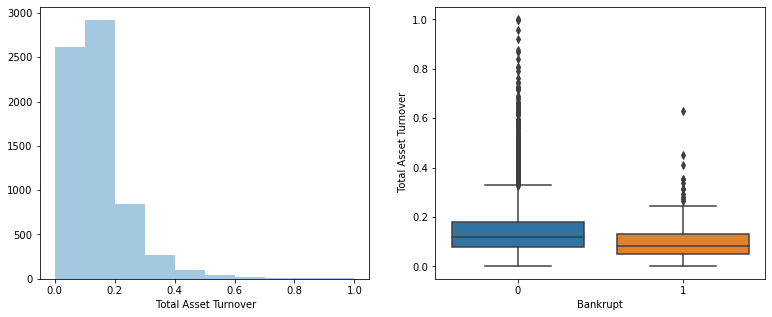

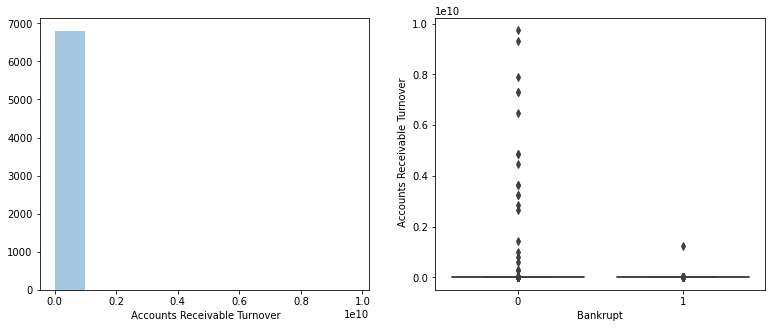

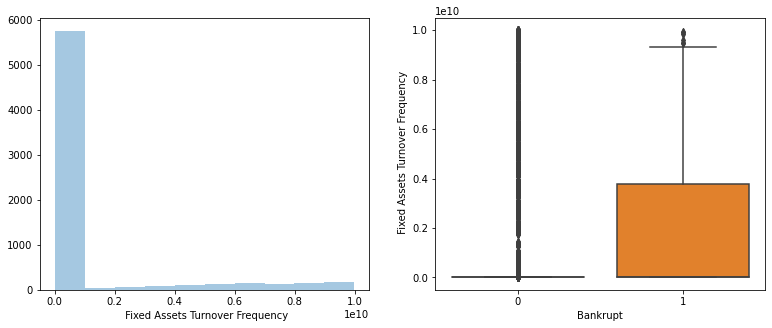

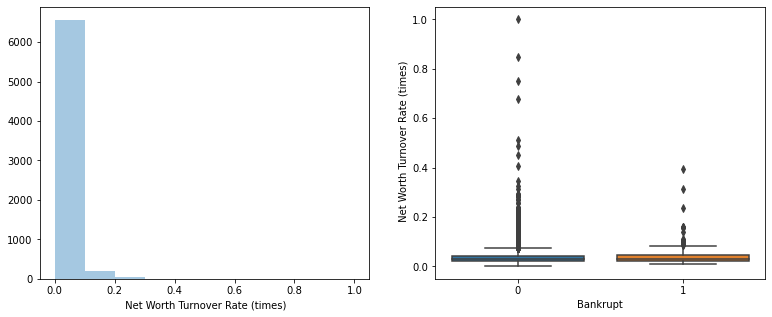

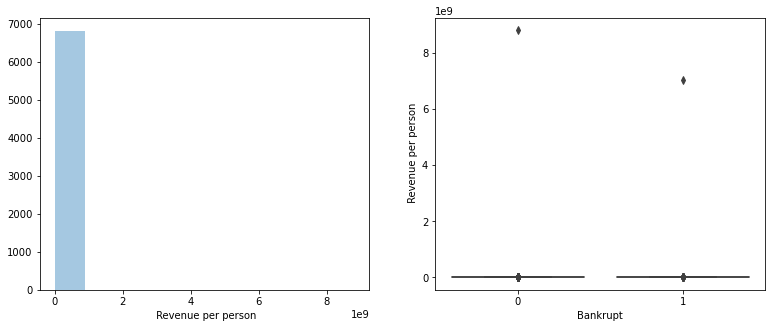

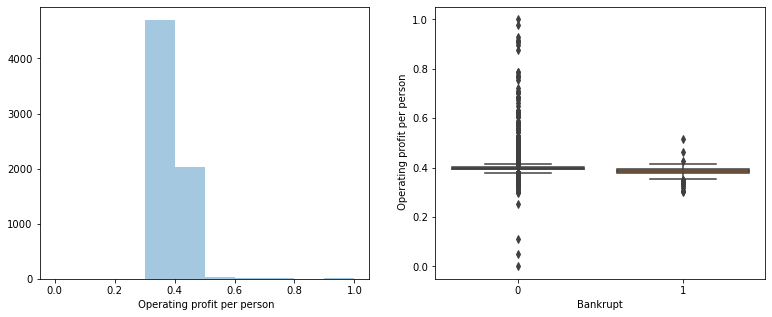

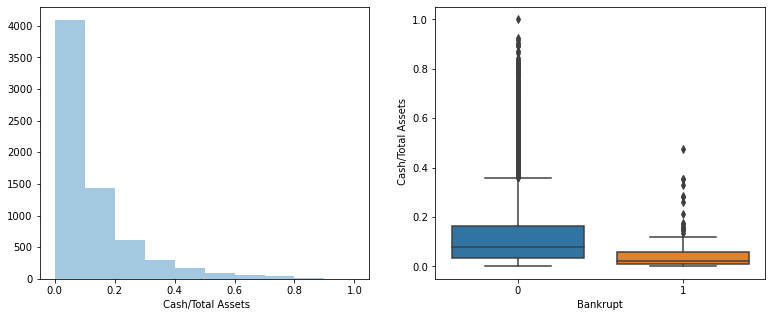

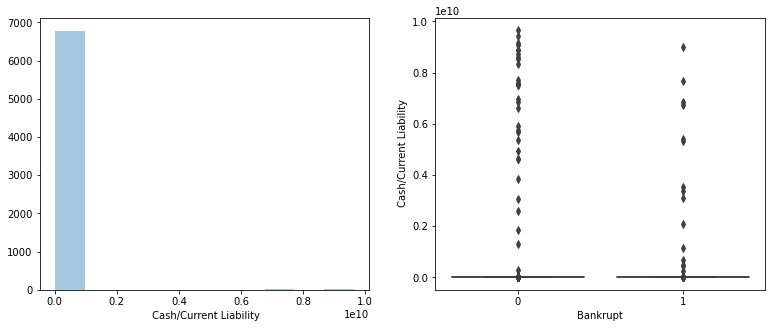

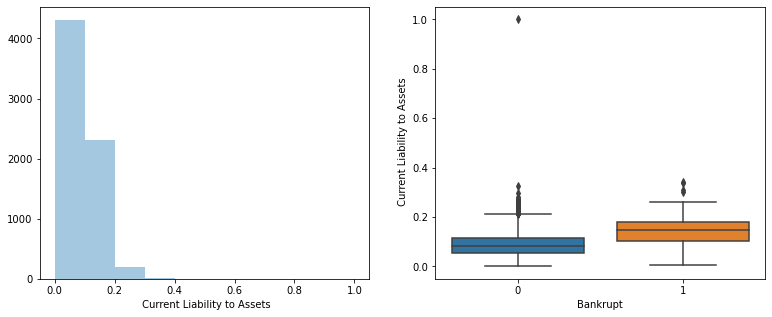

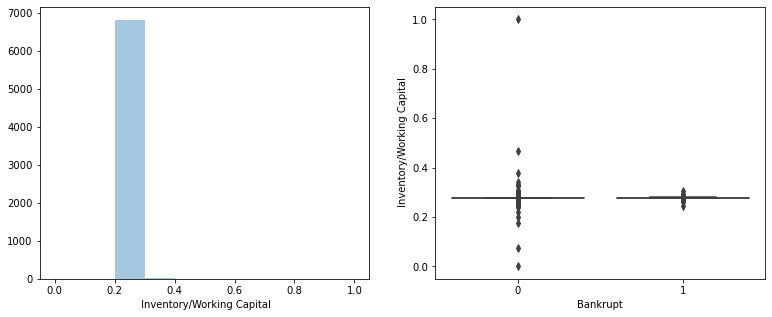

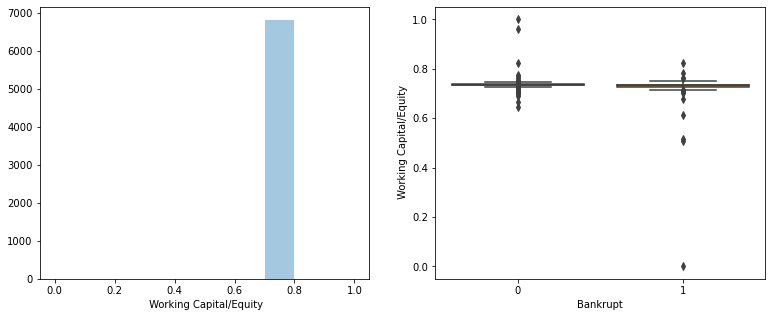

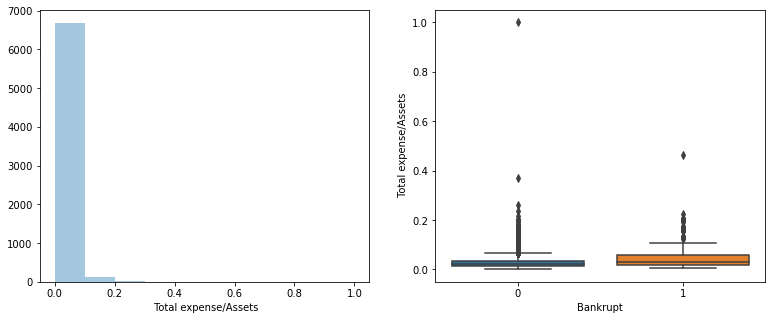

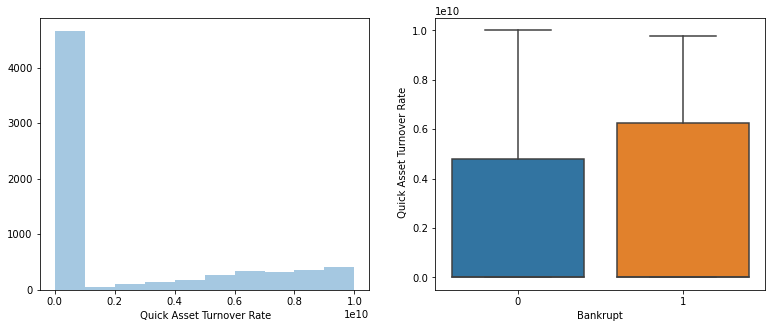

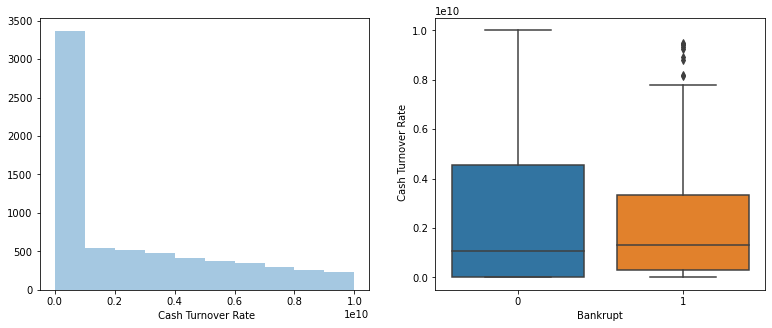

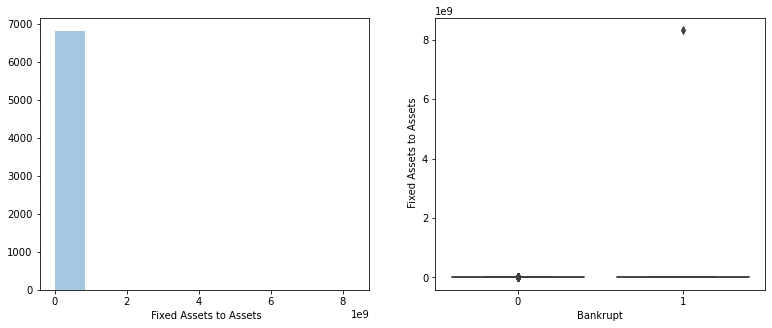

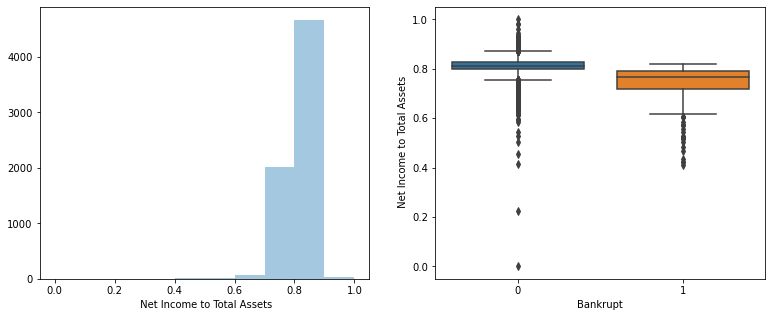

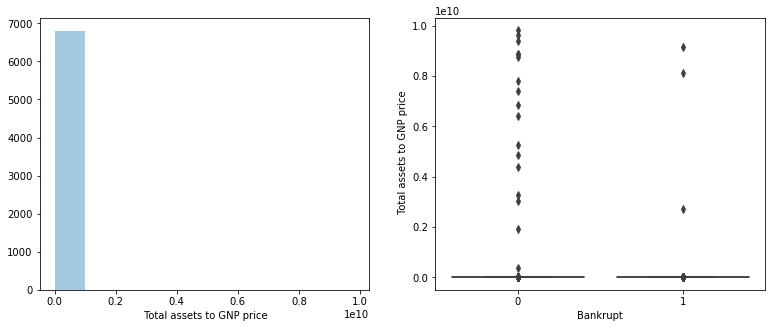

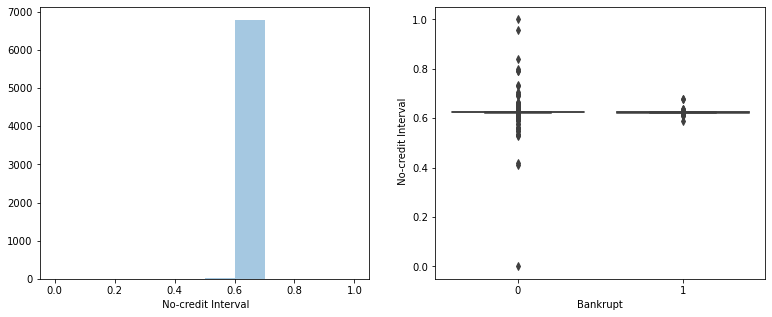

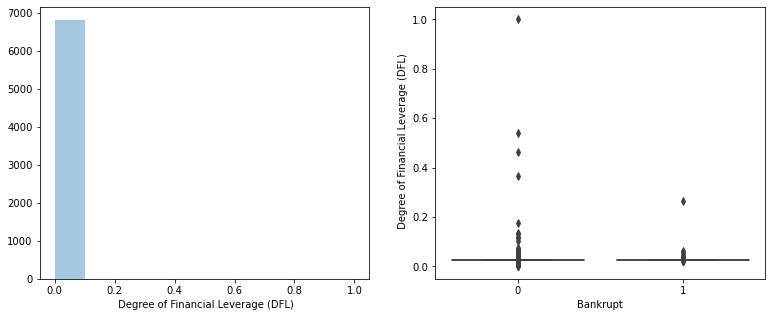

In [25]:
cols = data_df.drop(['Bankrupt'], axis=1).columns 

for feature in cols:
    fig, ax = plt.subplots(ncols=2,figsize=(13,5))
    sns.distplot(data_df[feature], bins=10, kde=False,ax=ax[0])
    sns.boxplot('Bankrupt', data_df[feature], data=data_df,ax=ax[1])

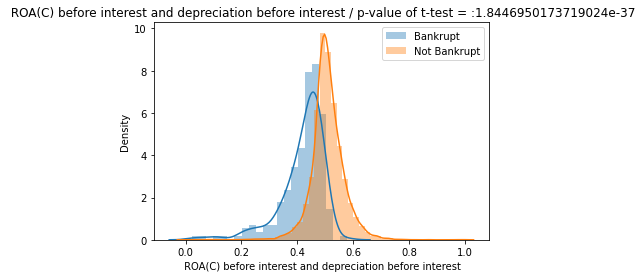

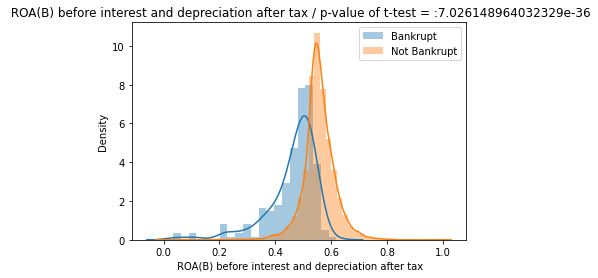

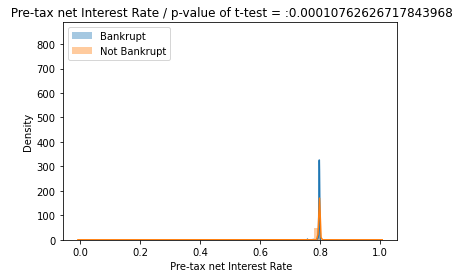

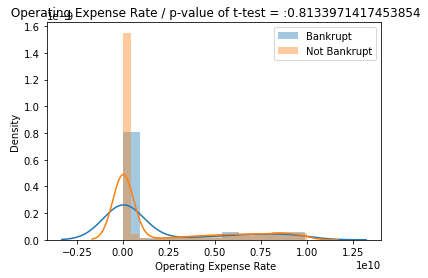

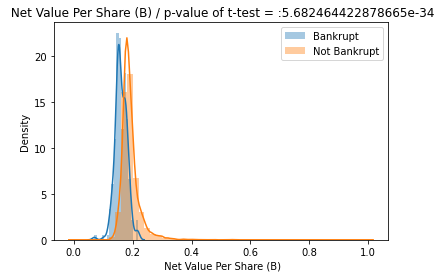

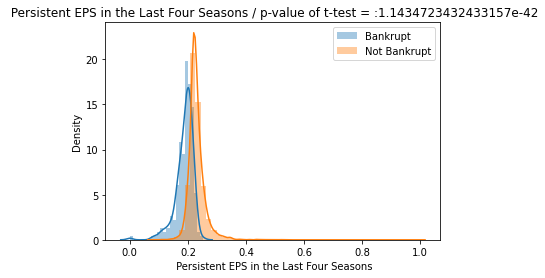

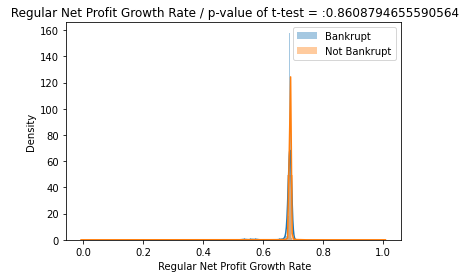

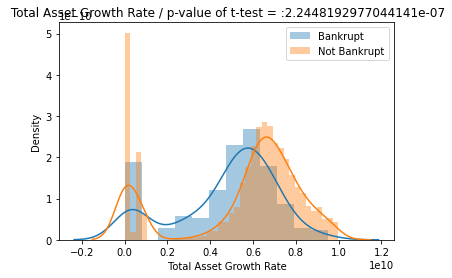

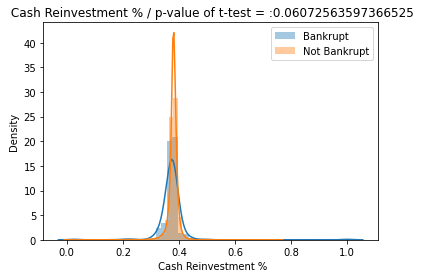

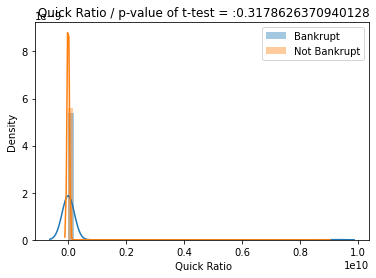

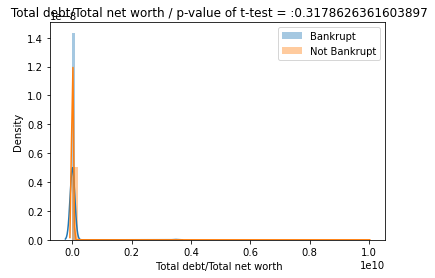

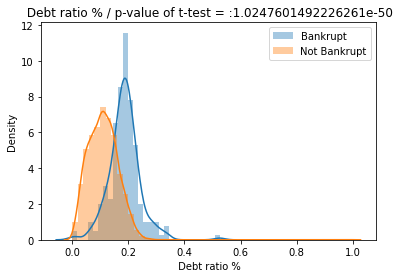

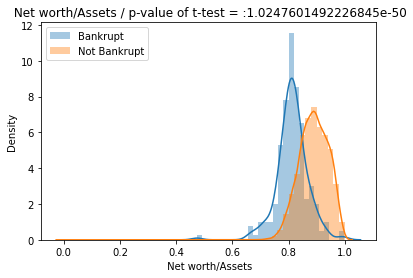

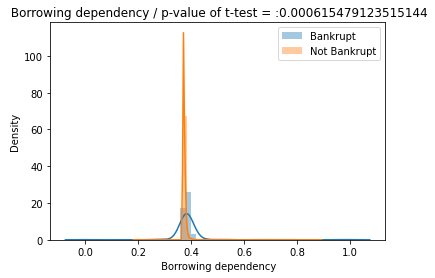

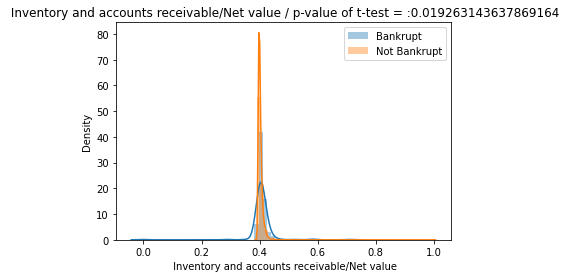

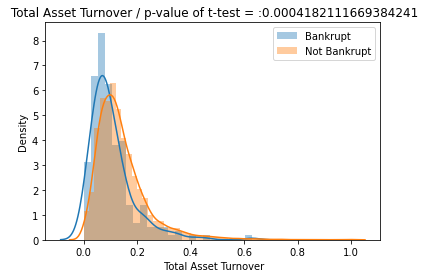

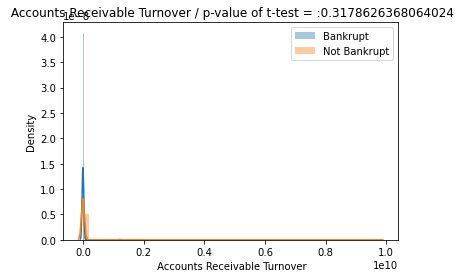

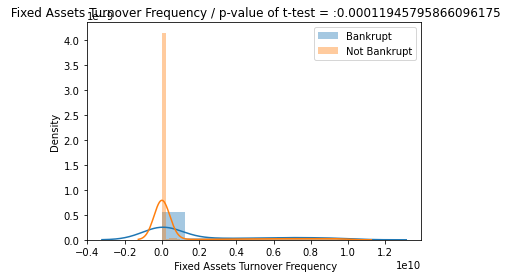

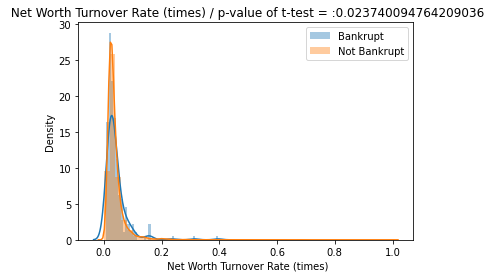

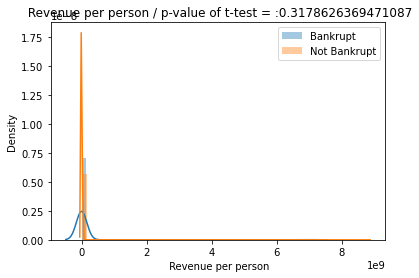

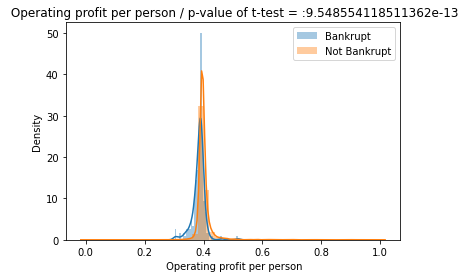

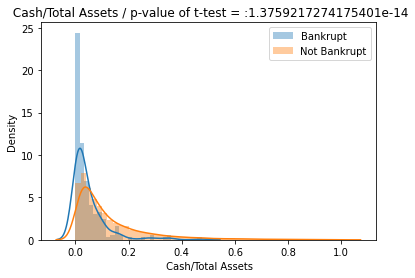

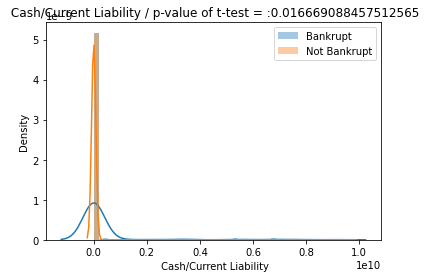

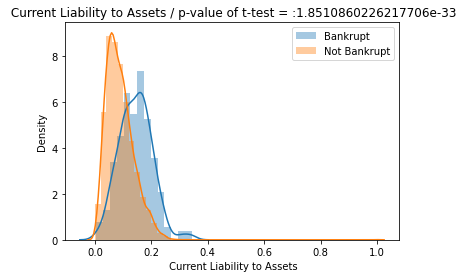

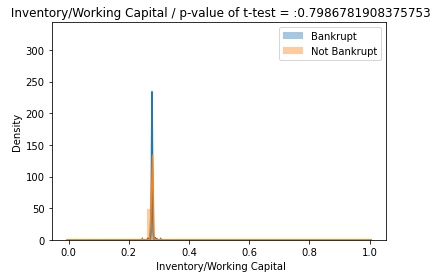

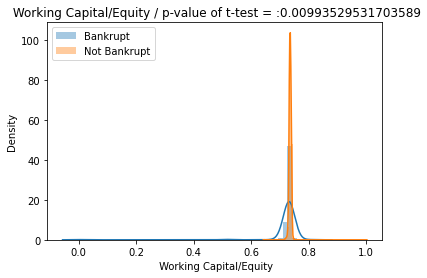

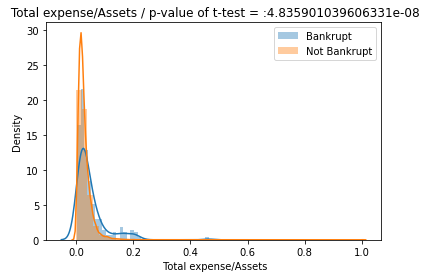

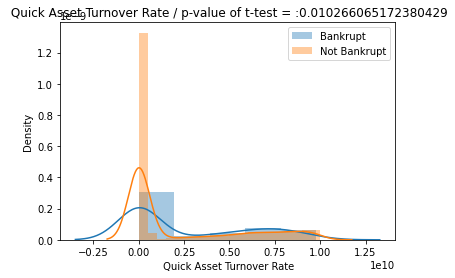

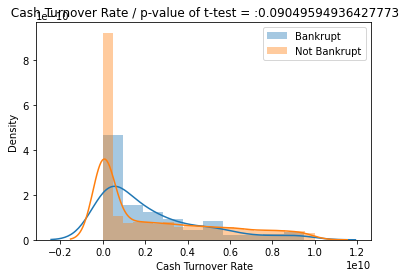

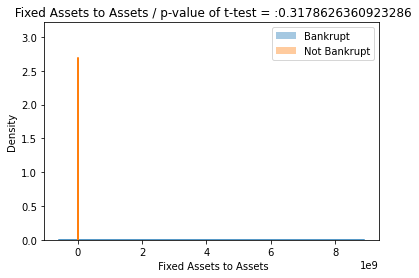

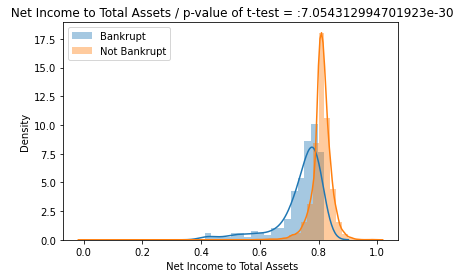

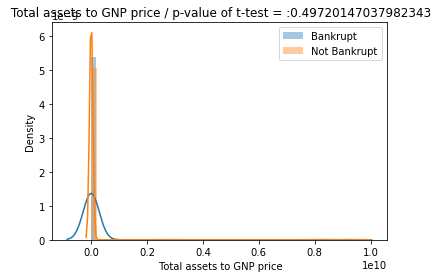

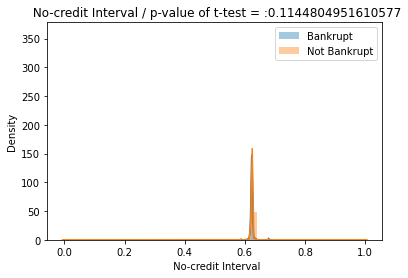

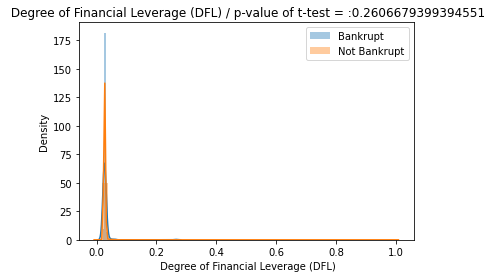

In [26]:
bankrupt = data_df[data_df['Bankrupt']==1]
not_bankrupt = data_df[data_df['Bankrupt']==0]
cols = data_df.drop(['Bankrupt'], axis=1).columns 

for feature in cols:
    a = bankrupt[feature]
    b = not_bankrupt[feature]
    b = b.sample(n=len(a), random_state=2021)
    test = stats.ttest_ind(a,b)   
    plt.figure() 
    sns.distplot(bankrupt[feature], kde= True, label="Bankrupt")
    sns.distplot(not_bankrupt[feature], kde= True, label="Not Bankrupt") 
    plt.title("{} / p-value of t-test = :{}".format(feature, test[1]))
    plt.legend() 

### ########################################################################################

### Metrics

In [27]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    f1 = f1_score(y_test,pred)
    f2 = fbeta_score(y_test,pred,beta=2)
    balanced_acc = balanced_accuracy_score(y_test,pred)
    G_Mean = geometric_mean_score(y_test,pred)
    MCC = matthews_corrcoef(y_test,pred)
    print(confusion)
    print('정확도:',accuracy.round(3),'정밀도:', precision.round(3),'재현율:',recall.round(3),'AUC:',roc_auc.round(3),'F1:',f1.round(3),'F2:',f2.round(3),'Balanced_Accuracy:',balanced_acc.round(3),'G-Mean:',G_Mean.round(3),'\n','matthews_corrcoef:',MCC.round(3))

### Baseline Model은 #1번 노트에 표시 

### Resampling 1.) SMOTE

In [28]:
from imblearn.over_sampling import SMOTE

#### SMOTE GBM 0.7~1.0

In [29]:
smote1 = SMOTE(sampling_strategy=0.7)
X_train_smote1,y_train_smote1 = smote1.fit_resample(X_train,y_train)

gbm_smote_1 = GradientBoostingClassifier(random_state=2021)
gbm_smote_1.fit(X_train_smote1,y_train_smote1)      
pred = gbm_smote_1.predict(X_test)
pred_proba = gbm_smote_1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote2 = SMOTE(sampling_strategy=0.75)
X_train_smote2,y_train_smote2 = smote2.fit_resample(X_train,y_train)

gbm_smote_2 = GradientBoostingClassifier(random_state=2021)
gbm_smote_2.fit(X_train_smote2,y_train_smote2)      
pred = gbm_smote_2.predict(X_test)
pred_proba = gbm_smote_2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote3 = SMOTE(sampling_strategy=0.8)
X_train_smote3,y_train_smote3 = smote3.fit_resample(X_train,y_train)

gbm_smote_3 = GradientBoostingClassifier(random_state=2021)
gbm_smote_3.fit(X_train_smote3,y_train_smote3)      
pred = gbm_smote_3.predict(X_test)
pred_proba = gbm_smote_3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote4 = SMOTE(sampling_strategy=0.85)
X_train_smote4,y_train_smote4 = smote4.fit_resample(X_train,y_train)

gbm_smote_4 = GradientBoostingClassifier(random_state=2021)
gbm_smote_4.fit(X_train_smote4,y_train_smote4)      
pred = gbm_smote_4.predict(X_test)
pred_proba = gbm_smote_4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote5 = SMOTE(sampling_strategy=0.9)
X_train_smote5,y_train_smote5 = smote5.fit_resample(X_train,y_train)

gbm_smote_5 = GradientBoostingClassifier(random_state=2021)
gbm_smote_5.fit(X_train_smote5,y_train_smote5)      
pred = gbm_smote_5.predict(X_test)
pred_proba = gbm_smote_5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote6 = SMOTE(sampling_strategy=0.95)
X_train_smote6,y_train_smote6 = smote6.fit_resample(X_train,y_train)

gbm_smote_6 = GradientBoostingClassifier(random_state=2021)
gbm_smote_6.fit(X_train_smote6,y_train_smote6)      
pred = gbm_smote_6.predict(X_test)
pred_proba = gbm_smote_6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote7 = SMOTE()
X_train_smote7,y_train_smote7 = smote7.fit_resample(X_train,y_train)

gbm_smote_7 = GradientBoostingClassifier(random_state=2021)
gbm_smote_7.fit(X_train_smote7,y_train_smote7)      
pred = gbm_smote_7.predict(X_test)
pred_proba = gbm_smote_7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[[1860  120]
 [  21   45]]
정확도: 0.931 정밀도: 0.273 재현율: 0.682 AUC: 0.925 F1: 0.39 F2: 0.524 Balanced_Accuracy: 0.811 G-Mean: 0.8 
 matthews_corrcoef: 0.403


[[1853  127]
 [  17   49]]
정확도: 0.93 정밀도: 0.278 재현율: 0.742 AUC: 0.922 F1: 0.405 F2: 0.557 Balanced_Accuracy: 0.839 G-Mean: 0.834 
 matthews_corrcoef: 0.427


[[1852  128]
 [  20   46]]
정확도: 0.928 정밀도: 0.264 재현율: 0.697 AUC: 0.928 F1: 0.383 F2: 0.525 Balanced_Accuracy: 0.816 G-Mean: 0.807 
 matthews_corrcoef: 0.401


[[1852  128]
 [  21   45]]
정확도: 0.927 정밀도: 0.26 재현율: 0.682 AUC: 0.925 F1: 0.377 F2: 0.515 Balanced_Accuracy: 0.809 G-Mean: 0.799 
 matthews_corrcoef: 0.392


[[1842  138]
 [  21   45]]
정확도: 0.922 정밀도: 0.246 재현율: 0.682 AUC: 0.923 F1: 0.361 F2: 0.503 Balanced_Accuracy: 0.806 G-Mean: 0.796 
 matthews_corrcoef: 0.379


[[1841  139]
 [  18   48]]
정확도: 0.923 정밀도: 0.257 재현율: 0.727 AUC: 0.926 F1: 0.379 F2: 0.532 Balanced_Accuracy: 0.829 G-Mean: 0.822 
 matthews_corrcoef: 0.403


[[1828  152]
 [  21   45]]
정확도: 0.915 정밀도: 0.228 재현

#### SMOTE LGBM 0.7~1.0

In [30]:
smote1 = SMOTE(sampling_strategy=0.7)
X_train_smote1,y_train_smote1 = smote1.fit_resample(X_train,y_train)

lgbm_smote_1 = LGBMClassifier(random_state=2021) 
lgbm_smote_1.fit(X_train_smote1,y_train_smote1)      
pred = lgbm_smote_1.predict(X_test)
pred_proba = lgbm_smote_1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)    
print('\n')

smote2 = SMOTE(sampling_strategy=0.75)
X_train_smote2,y_train_smote2 = smote2.fit_resample(X_train,y_train)

lgbm_smote_2 = LGBMClassifier(random_state=2021) 
lgbm_smote_2.fit(X_train_smote2,y_train_smote2)      
pred = lgbm_smote_2.predict(X_test)
pred_proba = lgbm_smote_2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)   
print('\n')

smote3 = SMOTE(sampling_strategy=0.8)
X_train_smote3,y_train_smote3 = smote3.fit_resample(X_train,y_train)

lgbm_smote_3 = LGBMClassifier(random_state=2021) 
lgbm_smote_3.fit(X_train_smote3,y_train_smote3)      
pred = lgbm_smote_3.predict(X_test)
pred_proba = lgbm_smote_3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)   
print('\n')

smote4 = SMOTE(sampling_strategy=0.85)
X_train_smote4,y_train_smote4 = smote4.fit_resample(X_train,y_train)

lgbm_smote_4 = LGBMClassifier(random_state=2021) 
lgbm_smote_4.fit(X_train_smote4,y_train_smote4)      
pred = lgbm_smote_4.predict(X_test)
pred_proba = lgbm_smote_4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)   
print('\n')

smote5 = SMOTE(sampling_strategy=0.9)
X_train_smote5,y_train_smote5 = smote5.fit_resample(X_train,y_train)

lgbm_smote_5 = LGBMClassifier(random_state=2021) 
lgbm_smote_5.fit(X_train_smote5,y_train_smote5)      
pred = lgbm_smote_5.predict(X_test)
pred_proba = lgbm_smote_5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)   
print('\n')

smote6 = SMOTE(sampling_strategy=0.95)
X_train_smote6,y_train_smote6 = smote6.fit_resample(X_train,y_train)

lgbm_smote_6 = LGBMClassifier(random_state=2021) 
lgbm_smote_6.fit(X_train_smote6,y_train_smote6)      
pred = lgbm_smote_6.predict(X_test)
pred_proba = lgbm_smote_6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)   
print('\n')

smote7 = SMOTE()
X_train_smote7,y_train_smote7 = smote7.fit_resample(X_train,y_train)

lgbm_smote_7 = LGBMClassifier(random_state=2021) 
lgbm_smote_7.fit(X_train_smote7,y_train_smote7)      
pred = lgbm_smote_7.predict(X_test)
pred_proba = lgbm_smote_7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)  

[[1922   58]
 [  27   39]]
정확도: 0.958 정밀도: 0.402 재현율: 0.591 AUC: 0.927 F1: 0.479 F2: 0.54 Balanced_Accuracy: 0.781 G-Mean: 0.757 
 matthews_corrcoef: 0.467


[[1923   57]
 [  29   37]]
정확도: 0.958 정밀도: 0.394 재현율: 0.561 AUC: 0.938 F1: 0.462 F2: 0.517 Balanced_Accuracy: 0.766 G-Mean: 0.738 
 matthews_corrcoef: 0.449


[[1918   62]
 [  25   41]]
정확도: 0.957 정밀도: 0.398 재현율: 0.621 AUC: 0.933 F1: 0.485 F2: 0.559 Balanced_Accuracy: 0.795 G-Mean: 0.776 
 matthews_corrcoef: 0.477


[[1918   62]
 [  26   40]]
정확도: 0.957 정밀도: 0.392 재현율: 0.606 AUC: 0.929 F1: 0.476 F2: 0.546 Balanced_Accuracy: 0.787 G-Mean: 0.766 
 matthews_corrcoef: 0.467


[[1923   57]
 [  24   42]]
정확도: 0.96 정밀도: 0.424 재현율: 0.636 AUC: 0.937 F1: 0.509 F2: 0.579 Balanced_Accuracy: 0.804 G-Mean: 0.786 
 matthews_corrcoef: 0.5


[[1918   62]
 [  24   42]]
정확도: 0.958 정밀도: 0.404 재현율: 0.636 AUC: 0.933 F1: 0.494 F2: 0.571 Balanced_Accuracy: 0.803 G-Mean: 0.785 
 matthews_corrcoef: 0.487


[[1919   61]
 [  30   36]]
정확도: 0.956 정밀도: 0.371 재

#### SMOTE XGBoost 0.7~1.0

In [31]:
smote1 = SMOTE(sampling_strategy=0.7)
X_train_smote1,y_train_smote1 = smote1.fit_resample(X_train,y_train)

xgb_smote_1 = XGBClassifier(random_state=2021,subsample=0.8)
xgb_smote_1.fit(X_train_smote1,y_train_smote1)
pred = xgb_smote_1.predict(X_test)
pred_proba = xgb_smote_1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)         
print('\n')

smote2 = SMOTE(sampling_strategy=0.75)
X_train_smote2,y_train_smote2 = smote2.fit_resample(X_train,y_train)

xgb_smote_2 = XGBClassifier(random_state=2021,subsample=0.8)
xgb_smote_2.fit(X_train_smote2,y_train_smote2)
pred = xgb_smote_2.predict(X_test)
pred_proba = xgb_smote_2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)        
print('\n')

smote3 = SMOTE(sampling_strategy=0.8)
X_train_smote3,y_train_smote3 = smote3.fit_resample(X_train,y_train)

xgb_smote_3 = XGBClassifier(random_state=2021,subsample=0.8)
xgb_smote_3.fit(X_train_smote3,y_train_smote3)
pred = xgb_smote_3.predict(X_test)
pred_proba = xgb_smote_3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote4 = SMOTE(sampling_strategy=0.85)
X_train_smote4,y_train_smote4 = smote4.fit_resample(X_train,y_train)

xgb_smote_4 = XGBClassifier(random_state=2021,subsample=0.8)
xgb_smote_4.fit(X_train_smote4,y_train_smote4)
pred = xgb_smote_4.predict(X_test)
pred_proba = xgb_smote_4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote5 = SMOTE(sampling_strategy=0.9)
X_train_smote5,y_train_smote5 = smote5.fit_resample(X_train,y_train)

xgb_smote_5 = XGBClassifier(random_state=2021,subsample=0.8)
xgb_smote_5.fit(X_train_smote5,y_train_smote5)
pred = xgb_smote_5.predict(X_test)
pred_proba = xgb_smote_5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)        
print('\n')

smote6 = SMOTE(sampling_strategy=0.95)
X_train_smote6,y_train_smote6 = smote6.fit_resample(X_train,y_train)

xgb_smote_6 = XGBClassifier(random_state=2021,subsample=0.8)
xgb_smote_6.fit(X_train_smote6,y_train_smote6 )
pred = xgb_smote_6.predict(X_test)
pred_proba = xgb_smote_6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote7 = SMOTE()
X_train_smote7,y_train_smote7 = smote7.fit_resample(X_train,y_train)

xgb_smote_7 = XGBClassifier(random_state=2021,subsample=0.8)
xgb_smote_7.fit(X_train_smote7,y_train_smote7 )
pred = xgb_smote_7.predict(X_test)
pred_proba = xgb_smote_7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     

[17:18:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1917   63]
 [  24   42]]
정확도: 0.957 정밀도: 0.4 재현율: 0.636 AUC: 0.936 F1: 0.491 F2: 0.569 Balanced_Accuracy: 0.802 G-Mean: 0.785 
 matthews_corrcoef: 0.484


[17:18:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1923   57]
 [  30   36]]
정확도: 0.957 정밀도: 0.387 재현율: 0.545 AUC: 0.93 F1: 0.453 F2: 0.504 Balanced_Accuracy: 0.758 G-Mean: 0.728 
 matthews_corrcoef: 0.438


[17:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win6

### Resampling 2.) ROSE

In [32]:
from imblearn.over_sampling import RandomOverSampler

#### ROSE GBM

In [33]:
rose1 = RandomOverSampler(sampling_strategy=0.7)
X_train_rose1,y_train_rose1 = rose1.fit_resample(X_train,y_train)

gbm_rose_1 = GradientBoostingClassifier(random_state=2021)
gbm_rose_1.fit(X_train_rose1,y_train_rose1)      
pred = gbm_rose_1.predict(X_test)
pred_proba = gbm_rose_1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose2 = RandomOverSampler(sampling_strategy=0.75)
X_train_rose2,y_train_rose2 = rose2.fit_resample(X_train,y_train)

gbm_rose_2 = GradientBoostingClassifier(random_state=2021)
gbm_rose_2.fit(X_train_rose2,y_train_rose2)      
pred = gbm_rose_2.predict(X_test)
pred_proba = gbm_rose_2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose3 = RandomOverSampler(sampling_strategy=0.8)
X_train_rose3,y_train_rose3 = rose3.fit_resample(X_train,y_train)

gbm_rose_3 = GradientBoostingClassifier(random_state=2021)
gbm_rose_3.fit(X_train_rose3,y_train_rose3)      
pred = gbm_rose_3.predict(X_test)
pred_proba = gbm_rose_3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose4 = RandomOverSampler(sampling_strategy=0.85)
X_train_rose4,y_train_rose4 = rose4.fit_resample(X_train,y_train)

gbm_rose_4 = GradientBoostingClassifier(random_state=2021)
gbm_rose_4.fit(X_train_rose4,y_train_rose4)      
pred = gbm_rose_4.predict(X_test)
pred_proba = gbm_rose_4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose5 = RandomOverSampler(sampling_strategy=0.9)
X_train_rose5,y_train_rose5 = rose5.fit_resample(X_train,y_train)

gbm_rose_5 = GradientBoostingClassifier(random_state=2021)
gbm_rose_5.fit(X_train_rose5,y_train_rose5)      
pred = gbm_rose_5.predict(X_test)
pred_proba = gbm_rose_5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose6 = RandomOverSampler(sampling_strategy=0.95)
X_train_rose6,y_train_rose6 = rose6.fit_resample(X_train,y_train)

gbm_rose_6 = GradientBoostingClassifier(random_state=2021)
gbm_rose_6.fit(X_train_rose6,y_train_rose6)      
pred = gbm_rose_6.predict(X_test)
pred_proba = gbm_rose_6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose7 = RandomOverSampler()
X_train_rose7,y_train_rose7 = rose7.fit_resample(X_train,y_train)

gbm_rose_7 = GradientBoostingClassifier(random_state=2021)
gbm_rose_7.fit(X_train_rose7,y_train_rose7)      
pred = gbm_rose_7.predict(X_test)
pred_proba = gbm_rose_7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[[1875  105]
 [  21   45]]
정확도: 0.938 정밀도: 0.3 재현율: 0.682 AUC: 0.932 F1: 0.417 F2: 0.543 Balanced_Accuracy: 0.814 G-Mean: 0.804 
 matthews_corrcoef: 0.426


[[1869  111]
 [  19   47]]
정확도: 0.936 정밀도: 0.297 재현율: 0.712 AUC: 0.929 F1: 0.42 F2: 0.557 Balanced_Accuracy: 0.828 G-Mean: 0.82 
 matthews_corrcoef: 0.434


[[1877  103]
 [  21   45]]
정확도: 0.939 정밀도: 0.304 재현율: 0.682 AUC: 0.928 F1: 0.421 F2: 0.546 Balanced_Accuracy: 0.815 G-Mean: 0.804 
 matthews_corrcoef: 0.43


[[1866  114]
 [  18   48]]
정확도: 0.935 정밀도: 0.296 재현율: 0.727 AUC: 0.932 F1: 0.421 F2: 0.563 Balanced_Accuracy: 0.835 G-Mean: 0.828 
 matthews_corrcoef: 0.438


[[1856  124]
 [  19   47]]
정확도: 0.93 정밀도: 0.275 재현율: 0.712 AUC: 0.928 F1: 0.397 F2: 0.54 Balanced_Accuracy: 0.825 G-Mean: 0.817 
 matthews_corrcoef: 0.415


[[1854  126]
 [  17   49]]
정확도: 0.93 정밀도: 0.28 재현율: 0.742 AUC: 0.927 F1: 0.407 F2: 0.558 Balanced_Accuracy: 0.839 G-Mean: 0.834 
 matthews_corrcoef: 0.429


[[1861  119]
 [  18   48]]
정확도: 0.933 정밀도: 0.287 재현율: 0

#### ROSE LGBM

In [34]:
rose1 = RandomOverSampler(sampling_strategy=0.7)
X_train_rose1,y_train_rose1 = rose1.fit_resample(X_train,y_train)

lgbm_rose_1 = LGBMClassifier(random_state=2021)
lgbm_rose_1.fit(X_train_rose1,y_train_rose1)      
pred = lgbm_rose_1.predict(X_test)
pred_proba = lgbm_rose_1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose2 = RandomOverSampler(sampling_strategy=0.75)
X_train_rose2,y_train_rose2 = rose2.fit_resample(X_train,y_train)

lgbm_rose_2 = LGBMClassifier(random_state=2021)
lgbm_rose_2.fit(X_train_rose2,y_train_rose2)      
pred = lgbm_rose_2.predict(X_test)
pred_proba = lgbm_rose_2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose3 = RandomOverSampler(sampling_strategy=0.8)
X_train_rose3,y_train_rose3 = rose3.fit_resample(X_train,y_train)

lgbm_rose_3 = LGBMClassifier(random_state=2021)
lgbm_rose_3.fit(X_train_rose3,y_train_rose3)      
pred = lgbm_rose_3.predict(X_test)
pred_proba = lgbm_rose_3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose4 = RandomOverSampler(sampling_strategy=0.85)
X_train_rose4,y_train_rose4 = rose4.fit_resample(X_train,y_train)

lgbm_rose_4 = LGBMClassifier(random_state=2021)
lgbm_rose_4.fit(X_train_rose4,y_train_rose4)      
pred = lgbm_rose_4.predict(X_test)
pred_proba = lgbm_rose_4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose5 = RandomOverSampler(sampling_strategy=0.9)
X_train_rose5,y_train_rose5 = rose5.fit_resample(X_train,y_train)

lgbm_rose_5 = LGBMClassifier(random_state=2021)
lgbm_rose_5.fit(X_train_rose5,y_train_rose5)      
pred = lgbm_rose_5.predict(X_test)
pred_proba = lgbm_rose_5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose6 = RandomOverSampler(sampling_strategy=0.95)
X_train_rose6,y_train_rose6 = rose6.fit_resample(X_train,y_train)

lgbm_rose_6 = LGBMClassifier(random_state=2021)
lgbm_rose_6.fit(X_train_rose6,y_train_rose6)      
pred = lgbm_rose_6.predict(X_test)
pred_proba = lgbm_rose_6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose7 = RandomOverSampler()
X_train_rose7,y_train_rose7 = rose7.fit_resample(X_train,y_train)

lgbm_rose_7 = LGBMClassifier(random_state=2021)
lgbm_rose_7.fit(X_train_rose7,y_train_rose7)      
pred = lgbm_rose_7.predict(X_test)
pred_proba = lgbm_rose_7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[[1952   28]
 [  42   24]]
정확도: 0.966 정밀도: 0.462 재현율: 0.364 AUC: 0.927 F1: 0.407 F2: 0.38 Balanced_Accuracy: 0.675 G-Mean: 0.599 
 matthews_corrcoef: 0.392


[[1949   31]
 [  39   27]]
정확도: 0.966 정밀도: 0.466 재현율: 0.409 AUC: 0.922 F1: 0.435 F2: 0.419 Balanced_Accuracy: 0.697 G-Mean: 0.635 
 matthews_corrcoef: 0.419


[[1952   28]
 [  40   26]]
정확도: 0.967 정밀도: 0.481 재현율: 0.394 AUC: 0.926 F1: 0.433 F2: 0.409 Balanced_Accuracy: 0.69 G-Mean: 0.623 
 matthews_corrcoef: 0.419


[[1953   27]
 [  38   28]]
정확도: 0.968 정밀도: 0.509 재현율: 0.424 AUC: 0.93 F1: 0.463 F2: 0.439 Balanced_Accuracy: 0.705 G-Mean: 0.647 
 matthews_corrcoef: 0.449


[[1947   33]
 [  39   27]]
정확도: 0.965 정밀도: 0.45 재현율: 0.409 AUC: 0.928 F1: 0.429 F2: 0.417 Balanced_Accuracy: 0.696 G-Mean: 0.634 
 matthews_corrcoef: 0.411


[[1947   33]
 [  39   27]]
정확도: 0.965 정밀도: 0.45 재현율: 0.409 AUC: 0.929 F1: 0.429 F2: 0.417 Balanced_Accuracy: 0.696 G-Mean: 0.634 
 matthews_corrcoef: 0.411


[[1949   31]
 [  37   29]]
정확도: 0.967 정밀도: 0.483 재현

#### ROSE XGB

In [35]:
rose1 = RandomOverSampler(sampling_strategy=0.7)
X_train_rose1,y_train_rose1 = rose1.fit_resample(X_train,y_train)

xgb_rose_1 = XGBClassifier(random_state=2021)
xgb_rose_1.fit(X_train_rose1,y_train_rose1)      
pred = xgb_rose_1.predict(X_test)
pred_proba = xgb_rose_1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose2 = RandomOverSampler(sampling_strategy=0.75)
X_train_rose2,y_train_rose2 = rose2.fit_resample(X_train,y_train)

xgb_rose_2 = XGBClassifier(random_state=2021)
xgb_rose_2.fit(X_train_rose2,y_train_rose2)      
pred = xgb_rose_2.predict(X_test)
pred_proba = xgb_rose_2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose3 = RandomOverSampler(sampling_strategy=0.8)
X_train_rose3,y_train_rose3 = rose3.fit_resample(X_train,y_train)

xgb_rose_3 = XGBClassifier(random_state=2021)
xgb_rose_3.fit(X_train_rose3,y_train_rose3)      
pred = xgb_rose_3.predict(X_test)
pred_proba = xgb_rose_3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose4 = RandomOverSampler(sampling_strategy=0.85)
X_train_rose4,y_train_rose4 = rose4.fit_resample(X_train,y_train)

xgb_rose_4 = XGBClassifier(random_state=2021)
xgb_rose_4.fit(X_train_rose4,y_train_rose4)      
pred = xgb_rose_4.predict(X_test)
pred_proba = xgb_rose_4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose5 = RandomOverSampler(sampling_strategy=0.9)
X_train_rose5,y_train_rose5 = rose5.fit_resample(X_train,y_train)

xgb_rose_5 = XGBClassifier(random_state=2021)
xgb_rose_5.fit(X_train_rose5,y_train_rose5)      
pred = xgb_rose_5.predict(X_test)
pred_proba = xgb_rose_5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose6 = RandomOverSampler(sampling_strategy=0.95)
X_train_rose6,y_train_rose6 = rose6.fit_resample(X_train,y_train)

xgb_rose_6 = XGBClassifier(random_state=2021)
xgb_rose_6.fit(X_train_rose6,y_train_rose6)      
pred = xgb_rose_6.predict(X_test)
pred_proba = xgb_rose_6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

rose7 = RandomOverSampler()
X_train_rose7,y_train_rose7 = rose7.fit_resample(X_train,y_train)

xgb_rose_7 = XGBClassifier(random_state=2021)
xgb_rose_7.fit(X_train_rose7,y_train_rose7)      
pred = xgb_rose_7.predict(X_test)
pred_proba = xgb_rose_7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[17:19:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1951   29]
 [  42   24]]
정확도: 0.965 정밀도: 0.453 재현율: 0.364 AUC: 0.918 F1: 0.403 F2: 0.379 Balanced_Accuracy: 0.674 G-Mean: 0.599 
 matthews_corrcoef: 0.388


[17:19:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1953   27]
 [  42   24]]
정확도: 0.966 정밀도: 0.471 재현율: 0.364 AUC: 0.923 F1: 0.41 F2: 0.381 Balanced_Accuracy: 0.675 G-Mean: 0.599 
 matthews_corrcoef: 0.397


[17:19:44] WARNING: C:/Users/Administrator/workspace/xgboost-wi

### Resampling 3.) ADASYN

In [1]:
from imblearn.over_sampling import ADASYN

#### ADASYN GBM

In [37]:
ads1 = ADASYN(sampling_strategy=0.7)
X_train_ads1,y_train_ads1 = ads1.fit_resample(X_train,y_train)

gbm_ads1 = GradientBoostingClassifier(random_state=2021)
gbm_ads1.fit(X_train_ads1,y_train_ads1)      
pred = gbm_ads1.predict(X_test)
pred_proba = gbm_ads1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads2 = ADASYN(sampling_strategy=0.75)
X_train_ads2,y_train_ads2 = ads2.fit_resample(X_train,y_train)

gbm_ads2 = GradientBoostingClassifier(random_state=2021)
gbm_ads2.fit(X_train_ads2,y_train_ads2)      
pred = gbm_ads2.predict(X_test)
pred_proba = gbm_ads2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads3 = ADASYN(sampling_strategy=0.8)
X_train_ads3,y_train_ads3 = ads3.fit_resample(X_train,y_train)

gbm_ads3 = GradientBoostingClassifier(random_state=2021)
gbm_ads3.fit(X_train_ads3,y_train_ads3)      
pred = gbm_ads3.predict(X_test)
pred_proba = gbm_ads3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads4 = ADASYN(sampling_strategy=0.85)
X_train_ads4,y_train_ads4 = ads4.fit_resample(X_train,y_train)

gbm_ads4 = GradientBoostingClassifier(random_state=2021)
gbm_ads4.fit(X_train_ads4,y_train_ads4)      
pred = gbm_ads4.predict(X_test)
pred_proba = gbm_ads4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads5 = ADASYN(sampling_strategy=0.9)
X_train_ads5,y_train_ads5 = ads5.fit_resample(X_train,y_train)

gbm_ads5 = GradientBoostingClassifier(random_state=2021)
gbm_ads5.fit(X_train_ads5,y_train_ads5)      
pred = gbm_ads5.predict(X_test)
pred_proba = gbm_ads5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads6 = ADASYN(sampling_strategy=0.95)
X_train_ads6,y_train_ads6 = ads6.fit_resample(X_train,y_train)

gbm_ads6 = GradientBoostingClassifier(random_state=2021)
gbm_ads6.fit(X_train_ads6,y_train_ads6)      
pred = gbm_ads6.predict(X_test)
pred_proba = gbm_ads6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads7 = ADASYN()
X_train_ads7,y_train_ads7 = ads7.fit_resample(X_train,y_train)

gbm_ads7 = GradientBoostingClassifier(random_state=2021)
gbm_ads7.fit(X_train_ads7,y_train_ads7)      
pred = gbm_ads7.predict(X_test)
pred_proba = gbm_ads7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[[1856  124]
 [  22   44]]
정확도: 0.929 정밀도: 0.262 재현율: 0.667 AUC: 0.927 F1: 0.376 F2: 0.509 Balanced_Accuracy: 0.802 G-Mean: 0.791 
 matthews_corrcoef: 0.389


[[1851  129]
 [  19   47]]
정확도: 0.928 정밀도: 0.267 재현율: 0.712 AUC: 0.929 F1: 0.388 F2: 0.534 Balanced_Accuracy: 0.823 G-Mean: 0.816 
 matthews_corrcoef: 0.408


[[1853  127]
 [  18   48]]
정확도: 0.929 정밀도: 0.274 재현율: 0.727 AUC: 0.928 F1: 0.398 F2: 0.547 Balanced_Accuracy: 0.832 G-Mean: 0.825 
 matthews_corrcoef: 0.419


[[1841  139]
 [  20   46]]
정확도: 0.922 정밀도: 0.249 재현율: 0.697 AUC: 0.922 F1: 0.367 F2: 0.512 Balanced_Accuracy: 0.813 G-Mean: 0.805 
 matthews_corrcoef: 0.386


[[1837  143]
 [  19   47]]
정확도: 0.921 정밀도: 0.247 재현율: 0.712 AUC: 0.924 F1: 0.367 F2: 0.518 Balanced_Accuracy: 0.82 G-Mean: 0.813 
 matthews_corrcoef: 0.39


[[1833  147]
 [  19   47]]
정확도: 0.919 정밀도: 0.242 재현율: 0.712 AUC: 0.927 F1: 0.362 F2: 0.513 Balanced_Accuracy: 0.819 G-Mean: 0.812 
 matthews_corrcoef: 0.385


[[1837  143]
 [  19   47]]
정확도: 0.921 정밀도: 0.247

#### ADASYN LGBM 

In [38]:
ads1 = ADASYN(sampling_strategy=0.7)
X_train_ads1,y_train_ads1 = ads1.fit_resample(X_train,y_train)

lgbm_ads1 = LGBMClassifier(random_state=2021)
lgbm_ads1.fit(X_train_ads1,y_train_ads1)      
pred = lgbm_ads1.predict(X_test)
pred_proba = lgbm_ads1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads2 = ADASYN(sampling_strategy=0.75)
X_train_ads2,y_train_ads2 = ads2.fit_resample(X_train,y_train)

lgbm_ads2 = LGBMClassifier(random_state=2021)
lgbm_ads2.fit(X_train_ads2,y_train_ads2)      
pred = lgbm_ads2.predict(X_test)
pred_proba = lgbm_ads2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads3 = ADASYN(sampling_strategy=0.8)
X_train_ads3,y_train_ads3 = ads3.fit_resample(X_train,y_train)

lgbm_ads3 = LGBMClassifier(random_state=2021)
lgbm_ads3.fit(X_train_ads3,y_train_ads3)      
pred = lgbm_ads3.predict(X_test)
pred_proba = lgbm_ads3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads4 = ADASYN(sampling_strategy=0.85)
X_train_ads4,y_train_ads4 = ads4.fit_resample(X_train,y_train)

lgbm_ads4 = LGBMClassifier(random_state=2021)
lgbm_ads4.fit(X_train_ads4,y_train_ads4)      
pred = lgbm_ads4.predict(X_test)
pred_proba = lgbm_ads4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads5 = ADASYN(sampling_strategy=0.9)
X_train_ads5,y_train_ads5 = ads5.fit_resample(X_train,y_train)

lgbm_ads5 = LGBMClassifier(random_state=2021)
lgbm_ads5.fit(X_train_ads5,y_train_ads5)      
pred = lgbm_ads5.predict(X_test)
pred_proba = lgbm_ads5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads6 = ADASYN(sampling_strategy=0.95)
X_train_ads6,y_train_ads6 = ads6.fit_resample(X_train,y_train)

lgbm_ads6 = LGBMClassifier(random_state=2021)
lgbm_ads6.fit(X_train_ads6,y_train_ads6)      
pred = lgbm_ads6.predict(X_test)
pred_proba = lgbm_ads6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads7 = ADASYN()
X_train_ads7,y_train_ads7 = ads7.fit_resample(X_train,y_train)

lgbm_ads7 = LGBMClassifier(random_state=2021)
lgbm_ads7.fit(X_train_ads7,y_train_ads7)      
pred = lgbm_ads7.predict(X_test)
pred_proba = lgbm_ads7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[[1919   61]
 [  24   42]]
정확도: 0.958 정밀도: 0.408 재현율: 0.636 AUC: 0.935 F1: 0.497 F2: 0.572 Balanced_Accuracy: 0.803 G-Mean: 0.785 
 matthews_corrcoef: 0.489


[[1923   57]
 [  25   41]]
정확도: 0.96 정밀도: 0.418 재현율: 0.621 AUC: 0.932 F1: 0.5 F2: 0.566 Balanced_Accuracy: 0.796 G-Mean: 0.777 
 matthews_corrcoef: 0.49


[[1924   56]
 [  26   40]]
정확도: 0.96 정밀도: 0.417 재현율: 0.606 AUC: 0.925 F1: 0.494 F2: 0.556 Balanced_Accuracy: 0.789 G-Mean: 0.767 
 matthews_corrcoef: 0.483


[[1919   61]
 [  26   40]]
정확도: 0.957 정밀도: 0.396 재현율: 0.606 AUC: 0.933 F1: 0.479 F2: 0.548 Balanced_Accuracy: 0.788 G-Mean: 0.766 
 matthews_corrcoef: 0.469


[[1920   60]
 [  25   41]]
정확도: 0.958 정밀도: 0.406 재현율: 0.621 AUC: 0.932 F1: 0.491 F2: 0.562 Balanced_Accuracy: 0.795 G-Mean: 0.776 
 matthews_corrcoef: 0.482


[[1915   65]
 [  26   40]]
정확도: 0.956 정밀도: 0.381 재현율: 0.606 AUC: 0.937 F1: 0.468 F2: 0.542 Balanced_Accuracy: 0.787 G-Mean: 0.766 
 matthews_corrcoef: 0.459


[[1915   65]
 [  26   40]]
정확도: 0.956 정밀도: 0.381 재현

#### ADASYN XGB

In [39]:
ads1 = ADASYN(sampling_strategy=0.7)
X_train_ads1,y_train_ads1 = ads1.fit_resample(X_train,y_train)

xgb_ads1 = XGBClassifier(random_state=2021)
xgb_ads1.fit(X_train_ads1,y_train_ads1)      
pred = xgb_ads1.predict(X_test)
pred_proba = xgb_ads1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads2 = ADASYN(sampling_strategy=0.75)
X_train_ads2,y_train_ads2 = ads2.fit_resample(X_train,y_train)

xgb_ads2 = XGBClassifier(random_state=2021)
xgb_ads2.fit(X_train_ads2,y_train_ads2)      
pred = xgb_ads2.predict(X_test)
pred_proba = xgb_ads2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads3 = ADASYN(sampling_strategy=0.8)
X_train_ads3,y_train_ads3 = ads3.fit_resample(X_train,y_train)

xgb_ads3 = XGBClassifier(random_state=2021)
xgb_ads3.fit(X_train_ads3,y_train_ads3)      
pred = xgb_ads3.predict(X_test)
pred_proba = xgb_ads3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads4 = ADASYN(sampling_strategy=0.85)
X_train_ads4,y_train_ads4 = ads4.fit_resample(X_train,y_train)

xgb_ads4 = XGBClassifier(random_state=2021)
xgb_ads4.fit(X_train_ads4,y_train_ads4)      
pred = xgb_ads4.predict(X_test)
pred_proba = xgb_ads4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads5 = ADASYN(sampling_strategy=0.9)
X_train_ads5,y_train_ads5 = ads5.fit_resample(X_train,y_train)

xgb_ads5 = XGBClassifier(random_state=2021)
xgb_ads5.fit(X_train_ads5,y_train_ads5)      
pred = xgb_ads5.predict(X_test)
pred_proba = xgb_ads5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads6 = ADASYN(sampling_strategy=0.95)
X_train_ads6,y_train_ads6 = ads6.fit_resample(X_train,y_train)

xgb_ads6 = XGBClassifier(random_state=2021)
xgb_ads6.fit(X_train_ads6,y_train_ads6)      
pred = xgb_ads6.predict(X_test)
pred_proba = xgb_ads6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

ads7 = ADASYN()
X_train_ads7,y_train_ads7 = ads7.fit_resample(X_train,y_train)

xgb_ads7 = XGBClassifier(random_state=2021)
xgb_ads7.fit(X_train_ads7,y_train_ads7)      
pred = xgb_ads7.predict(X_test)
pred_proba = xgb_ads7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[17:21:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1925   55]
 [  24   42]]
정확도: 0.961 정밀도: 0.433 재현율: 0.636 AUC: 0.926 F1: 0.515 F2: 0.582 Balanced_Accuracy: 0.804 G-Mean: 0.787 
 matthews_corrcoef: 0.506


[17:21:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1920   60]
 [  26   40]]
정확도: 0.958 정밀도: 0.4 재현율: 0.606 AUC: 0.922 F1: 0.482 F2: 0.549 Balanced_Accuracy: 0.788 G-Mean: 0.767 
 matthews_corrcoef: 0.472


[17:21:09] WARNING: C:/Users/Administrator/workspace/xgboost-win

### Resampling 4.) Borderline-SMOTE

In [40]:
from imblearn.over_sampling import BorderlineSMOTE

####  Borderline-SMOTE GBM

In [41]:
bd_smote1 = BorderlineSMOTE(sampling_strategy=0.7)
X_train_bd_smote1,y_train_bd_smote1 = bd_smote1.fit_resample(X_train,y_train)

gbm_bd_smote1 = GradientBoostingClassifier(random_state=2021)
gbm_bd_smote1.fit(X_train_bd_smote1,y_train_bd_smote1)      
pred = gbm_bd_smote1.predict(X_test)
pred_proba = gbm_bd_smote1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote2 = BorderlineSMOTE(sampling_strategy=0.75)
X_train_bd_smote2,y_train_bd_smote2 = bd_smote2.fit_resample(X_train,y_train)

gbm_bd_smote2 = GradientBoostingClassifier(random_state=2021)
gbm_bd_smote2.fit(X_train_bd_smote2,y_train_bd_smote2)      
pred = gbm_bd_smote2.predict(X_test)
pred_proba = gbm_bd_smote2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote3 = BorderlineSMOTE(sampling_strategy=0.8)
X_train_bd_smote3,y_train_bd_smote3 = bd_smote3.fit_resample(X_train,y_train)

gbm_bd_smote3 = GradientBoostingClassifier(random_state=2021)
gbm_bd_smote3.fit(X_train_bd_smote3,y_train_bd_smote3)      
pred = gbm_bd_smote3.predict(X_test)
pred_proba = gbm_bd_smote3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote4 =  BorderlineSMOTE(sampling_strategy=0.85)
X_train_bd_smote4,y_train_bd_smote4 = bd_smote4.fit_resample(X_train,y_train)

gbm_bd_smote4 = GradientBoostingClassifier(random_state=2021)
gbm_bd_smote4.fit(X_train_bd_smote4,y_train_bd_smote4)      
pred = gbm_bd_smote4.predict(X_test)
pred_proba = gbm_bd_smote4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote5 =  BorderlineSMOTE(sampling_strategy=0.9)
X_train_bd_smote5,y_train_bd_smote5 = bd_smote5.fit_resample(X_train,y_train)

gbm_bd_smote5 = GradientBoostingClassifier(random_state=2021)
gbm_bd_smote5.fit(X_train_bd_smote5,y_train_bd_smote5)      
pred = gbm_bd_smote5.predict(X_test)
pred_proba = gbm_bd_smote5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote6 =  BorderlineSMOTE(sampling_strategy=0.95)
X_train_bd_smote6,y_train_bd_smote6 = bd_smote6.fit_resample(X_train,y_train)

gbm_bd_smote6 = GradientBoostingClassifier(random_state=2021)
gbm_bd_smote6.fit(X_train_bd_smote6,y_train_bd_smote6)      
pred = gbm_bd_smote6.predict(X_test)
pred_proba = gbm_bd_smote6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote7 = BorderlineSMOTE()
X_train_bd_smote7,y_train_bd_smote7 = bd_smote7.fit_resample(X_train,y_train)

gbm_bd_smote7 = GradientBoostingClassifier(random_state=2021)
gbm_bd_smote7.fit(X_train_bd_smote7,y_train_bd_smote7)      
pred = gbm_bd_smote7.predict(X_test)
pred_proba = gbm_bd_smote7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[[1888   92]
 [  26   40]]
정확도: 0.942 정밀도: 0.303 재현율: 0.606 AUC: 0.919 F1: 0.404 F2: 0.505 Balanced_Accuracy: 0.78 G-Mean: 0.76 
 matthews_corrcoef: 0.402


[[1885   95]
 [  24   42]]
정확도: 0.942 정밀도: 0.307 재현율: 0.636 AUC: 0.917 F1: 0.414 F2: 0.524 Balanced_Accuracy: 0.794 G-Mean: 0.778 
 matthews_corrcoef: 0.416


[[1879  101]
 [  24   42]]
정확도: 0.939 정밀도: 0.294 재현율: 0.636 AUC: 0.92 F1: 0.402 F2: 0.516 Balanced_Accuracy: 0.793 G-Mean: 0.777 
 matthews_corrcoef: 0.406


[[1875  105]
 [  24   42]]
정확도: 0.937 정밀도: 0.286 재현율: 0.636 AUC: 0.922 F1: 0.394 F2: 0.511 Balanced_Accuracy: 0.792 G-Mean: 0.776 
 matthews_corrcoef: 0.399


[[1877  103]
 [  25   41]]
정확도: 0.937 정밀도: 0.285 재현율: 0.621 AUC: 0.916 F1: 0.39 F2: 0.502 Balanced_Accuracy: 0.785 G-Mean: 0.767 
 matthews_corrcoef: 0.393


[[1873  107]
 [  24   42]]
정확도: 0.936 정밀도: 0.282 재현율: 0.636 AUC: 0.92 F1: 0.391 F2: 0.508 Balanced_Accuracy: 0.791 G-Mean: 0.776 
 matthews_corrcoef: 0.396


[[1873  107]
 [  26   40]]
정확도: 0.935 정밀도: 0.272 재현

####  Borderline-SMOTE LGBM

In [42]:
bd_smote1 = BorderlineSMOTE(sampling_strategy=0.7)
X_train_bd_smote1,y_train_bd_smote1 = bd_smote1.fit_resample(X_train,y_train)

lgbm_bd_smote1 = LGBMClassifier(random_state=2021)
lgbm_bd_smote1.fit(X_train_bd_smote1,y_train_bd_smote1)      
pred = lgbm_bd_smote1.predict(X_test)
pred_proba = lgbm_bd_smote1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote2 = BorderlineSMOTE(sampling_strategy=0.75)
X_train_bd_smote2,y_train_bd_smote2 = bd_smote2.fit_resample(X_train,y_train)

lgbm_bd_smote2 = LGBMClassifier(random_state=2021)
lgbm_bd_smote2.fit(X_train_bd_smote2,y_train_bd_smote2)      
pred = lgbm_bd_smote2.predict(X_test)
pred_proba = lgbm_bd_smote2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote3 = BorderlineSMOTE(sampling_strategy=0.8)
X_train_bd_smote3,y_train_bd_smote3 = bd_smote3.fit_resample(X_train,y_train)

lgbm_bd_smote3 = LGBMClassifier(random_state=2021)
lgbm_bd_smote3.fit(X_train_bd_smote3,y_train_bd_smote3)      
pred = lgbm_bd_smote3.predict(X_test)
pred_proba = lgbm_bd_smote3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote4 =  BorderlineSMOTE(sampling_strategy=0.85)
X_train_bd_smote4,y_train_bd_smote4 = bd_smote4.fit_resample(X_train,y_train)

lgbm_bd_smote4 = LGBMClassifier(random_state=2021)
lgbm_bd_smote4.fit(X_train_bd_smote4,y_train_bd_smote4)      
pred = lgbm_bd_smote4.predict(X_test)
pred_proba = lgbm_bd_smote4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote5 =  BorderlineSMOTE(sampling_strategy=0.9)
X_train_bd_smote5,y_train_bd_smote5 = bd_smote5.fit_resample(X_train,y_train)

lgbm_bd_smote5 = LGBMClassifier(random_state=2021)
lgbm_bd_smote5.fit(X_train_bd_smote5,y_train_bd_smote5)      
pred = lgbm_bd_smote5.predict(X_test)
pred_proba = lgbm_bd_smote5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote6 =  BorderlineSMOTE(sampling_strategy=0.95)
X_train_bd_smote6,y_train_bd_smote6 = bd_smote6.fit_resample(X_train,y_train)

lgbm_bd_smote6 = LGBMClassifier(random_state=2021)
lgbm_bd_smote6.fit(X_train_bd_smote6,y_train_bd_smote6)      
pred = lgbm_bd_smote6.predict(X_test)
pred_proba = lgbm_bd_smote6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote7 = BorderlineSMOTE()
X_train_bd_smote7,y_train_bd_smote7 = bd_smote7.fit_resample(X_train,y_train)

lgbm_bd_smote7 = LGBMClassifier(random_state=2021)
lgbm_bd_smote7.fit(X_train_bd_smote7,y_train_bd_smote7)      
pred = lgbm_bd_smote7.predict(X_test)
pred_proba = lgbm_bd_smote7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[[1935   45]
 [  33   33]]
정확도: 0.962 정밀도: 0.423 재현율: 0.5 AUC: 0.937 F1: 0.458 F2: 0.482 Balanced_Accuracy: 0.739 G-Mean: 0.699 
 matthews_corrcoef: 0.44


[[1937   43]
 [  34   32]]
정확도: 0.962 정밀도: 0.427 재현율: 0.485 AUC: 0.926 F1: 0.454 F2: 0.472 Balanced_Accuracy: 0.732 G-Mean: 0.689 
 matthews_corrcoef: 0.435


[[1932   48]
 [  31   35]]
정확도: 0.961 정밀도: 0.422 재현율: 0.53 AUC: 0.929 F1: 0.47 F2: 0.504 Balanced_Accuracy: 0.753 G-Mean: 0.719 
 matthews_corrcoef: 0.453


[[1936   44]
 [  31   35]]
정확도: 0.963 정밀도: 0.443 재현율: 0.53 AUC: 0.931 F1: 0.483 F2: 0.51 Balanced_Accuracy: 0.754 G-Mean: 0.72 
 matthews_corrcoef: 0.466


[[1938   42]
 [  33   33]]
정확도: 0.963 정밀도: 0.44 재현율: 0.5 AUC: 0.928 F1: 0.468 F2: 0.487 Balanced_Accuracy: 0.739 G-Mean: 0.7 
 matthews_corrcoef: 0.45


[[1938   42]
 [  31   35]]
정확도: 0.964 정밀도: 0.455 재현율: 0.53 AUC: 0.931 F1: 0.49 F2: 0.513 Balanced_Accuracy: 0.755 G-Mean: 0.72 
 matthews_corrcoef: 0.473


[[1932   48]
 [  31   35]]
정확도: 0.961 정밀도: 0.422 재현율: 0.53 AUC:

####  Borderline-SMOTE XGB

In [43]:
bd_smote1 = BorderlineSMOTE(sampling_strategy=0.7)
X_train_bd_smote1,y_train_bd_smote1 = bd_smote1.fit_resample(X_train,y_train)

xgb_bd_smote1 = XGBClassifier(random_state=2021)
xgb_bd_smote1.fit(X_train_bd_smote1,y_train_bd_smote1)      
pred = xgb_bd_smote1.predict(X_test)
pred_proba = xgb_bd_smote1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote2 = BorderlineSMOTE(sampling_strategy=0.75)
X_train_bd_smote2,y_train_bd_smote2 = bd_smote2.fit_resample(X_train,y_train)

xgb_bd_smote2 = XGBClassifier(random_state=2021)
xgb_bd_smote2.fit(X_train_bd_smote2,y_train_bd_smote2)      
pred = xgb_bd_smote2.predict(X_test)
pred_proba = xgb_bd_smote2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote3 = BorderlineSMOTE(sampling_strategy=0.8)
X_train_bd_smote3,y_train_bd_smote3 = bd_smote3.fit_resample(X_train,y_train)

xgb_bd_smote3 = XGBClassifier(random_state=2021)
xgb_bd_smote3.fit(X_train_bd_smote3,y_train_bd_smote3)      
pred = xgb_bd_smote3.predict(X_test)
pred_proba = xgb_bd_smote3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote4 =  BorderlineSMOTE(sampling_strategy=0.85)
X_train_bd_smote4,y_train_bd_smote4 = bd_smote4.fit_resample(X_train,y_train)

xgb_bd_smote4 = XGBClassifier(random_state=2021)
xgb_bd_smote4.fit(X_train_bd_smote4,y_train_bd_smote4)      
pred = xgb_bd_smote4.predict(X_test)
pred_proba = xgb_bd_smote4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote5 =  BorderlineSMOTE(sampling_strategy=0.9)
X_train_bd_smote5,y_train_bd_smote5 = bd_smote5.fit_resample(X_train,y_train)

xgb_bd_smote5 = XGBClassifier(random_state=2021)
xgb_bd_smote5.fit(X_train_bd_smote5,y_train_bd_smote5)      
pred = xgb_bd_smote5.predict(X_test)
pred_proba = xgb_bd_smote5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote6 =  BorderlineSMOTE(sampling_strategy=0.95)
X_train_bd_smote6,y_train_bd_smote6 = bd_smote6.fit_resample(X_train,y_train)

xgb_bd_smote6 = XGBClassifier(random_state=2021)
xgb_bd_smote6.fit(X_train_bd_smote6,y_train_bd_smote6)      
pred = xgb_bd_smote6.predict(X_test)
pred_proba = xgb_bd_smote6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

bd_smote7 = BorderlineSMOTE()
X_train_bd_smote7,y_train_bd_smote7 = bd_smote7.fit_resample(X_train,y_train)

xgb_bd_smote7 = XGBClassifier(random_state=2021)
xgb_bd_smote7.fit(X_train_bd_smote7,y_train_bd_smote7)      
pred = xgb_bd_smote7.predict(X_test)
pred_proba = xgb_bd_smote7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[17:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1939   41]
 [  31   35]]
정확도: 0.965 정밀도: 0.461 재현율: 0.53 AUC: 0.921 F1: 0.493 F2: 0.515 Balanced_Accuracy: 0.755 G-Mean: 0.721 
 matthews_corrcoef: 0.476


[17:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1932   48]
 [  31   35]]
정확도: 0.961 정밀도: 0.422 재현율: 0.53 AUC: 0.929 F1: 0.47 F2: 0.504 Balanced_Accuracy: 0.753 G-Mean: 0.719 
 matthews_corrcoef: 0.453


[17:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win6

### Resampling 5.) SVM SMOTE

In [44]:
from imblearn.over_sampling import SVMSMOTE

####  SVM SMOTE GBM

In [45]:
svm_smote1 = SVMSMOTE(sampling_strategy=0.7)
X_train_svm_smote1,y_train_svm_smote1 = svm_smote1.fit_resample(X_train,y_train)

gbm_svm_smote1 = GradientBoostingClassifier(random_state=2021)
gbm_svm_smote1.fit(X_train_svm_smote1,y_train_svm_smote1)      
pred = gbm_svm_smote1.predict(X_test)
pred_proba = gbm_svm_smote1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote2 = SVMSMOTE(sampling_strategy=0.75)
X_train_svm_smote2,y_train_svm_smote2 = svm_smote2.fit_resample(X_train,y_train)

gbm_svm_smote2 = GradientBoostingClassifier(random_state=2021)
gbm_svm_smote2.fit(X_train_svm_smote2,y_train_svm_smote2)      
pred = gbm_svm_smote2.predict(X_test)
pred_proba = gbm_svm_smote2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote3 = SVMSMOTE(sampling_strategy=0.8)
X_train_svm_smote3,y_train_svm_smote3 = svm_smote3.fit_resample(X_train,y_train)

gbm_svm_smote3 = GradientBoostingClassifier(random_state=2021)
gbm_svm_smote3.fit(X_train_svm_smote3,y_train_svm_smote3)      
pred = gbm_svm_smote3.predict(X_test)
pred_proba = gbm_svm_smote3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote4 =  SVMSMOTE(sampling_strategy=0.85)
X_train_svm_smote4,y_train_svm_smote4 = svm_smote4.fit_resample(X_train,y_train)

gbm_svm_smote4 = GradientBoostingClassifier(random_state=2021)
gbm_svm_smote4.fit(X_train_svm_smote4,y_train_svm_smote4)      
pred = gbm_svm_smote4.predict(X_test)
pred_proba = gbm_svm_smote4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote5 =  SVMSMOTE(sampling_strategy=0.9)
X_train_svm_smote5,y_train_svm_smote5 = svm_smote5.fit_resample(X_train,y_train)

gbm_svm_smote5 = GradientBoostingClassifier(random_state=2021)
gbm_svm_smote5.fit(X_train_svm_smote5,y_train_svm_smote5)      
pred = gbm_svm_smote5.predict(X_test)
pred_proba = gbm_svm_smote5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote6 =  SVMSMOTE(sampling_strategy=0.95)
X_train_svm_smote6,y_train_svm_smote6 = svm_smote6.fit_resample(X_train,y_train)

gbm_svm_smote6 = GradientBoostingClassifier(random_state=2021)
gbm_svm_smote6.fit(X_train_svm_smote6,y_train_svm_smote6)      
pred = gbm_svm_smote6.predict(X_test)
pred_proba = gbm_svm_smote6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote7 = SVMSMOTE()
X_train_svm_smote7,y_train_svm_smote7 = svm_smote7.fit_resample(X_train,y_train)

gbm_svm_smote7 = GradientBoostingClassifier(random_state=2021)
gbm_svm_smote7.fit(X_train_svm_smote7,y_train_svm_smote7)      
pred = gbm_svm_smote7.predict(X_test)
pred_proba = gbm_svm_smote7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[[1917   63]
 [  27   39]]
정확도: 0.956 정밀도: 0.382 재현율: 0.591 AUC: 0.926 F1: 0.464 F2: 0.533 Balanced_Accuracy: 0.78 G-Mean: 0.756 
 matthews_corrcoef: 0.454


[[1896   84]
 [  27   39]]
정확도: 0.946 정밀도: 0.317 재현율: 0.591 AUC: 0.919 F1: 0.413 F2: 0.504 Balanced_Accuracy: 0.774 G-Mean: 0.752 
 matthews_corrcoef: 0.408


[[1917   63]
 [  27   39]]
정확도: 0.956 정밀도: 0.382 재현율: 0.591 AUC: 0.92 F1: 0.464 F2: 0.533 Balanced_Accuracy: 0.78 G-Mean: 0.756 
 matthews_corrcoef: 0.454


[[1903   77]
 [  26   40]]
정확도: 0.95 정밀도: 0.342 재현율: 0.606 AUC: 0.92 F1: 0.437 F2: 0.525 Balanced_Accuracy: 0.784 G-Mean: 0.763 
 matthews_corrcoef: 0.432


[[1906   74]
 [  29   37]]
정확도: 0.95 정밀도: 0.333 재현율: 0.561 AUC: 0.921 F1: 0.418 F2: 0.493 Balanced_Accuracy: 0.762 G-Mean: 0.735 
 matthews_corrcoef: 0.408


[[1901   79]
 [  26   40]]
정확도: 0.949 정밀도: 0.336 재현율: 0.606 AUC: 0.924 F1: 0.432 F2: 0.522 Balanced_Accuracy: 0.783 G-Mean: 0.763 
 matthews_corrcoef: 0.427


[[1894   86]
 [  25   41]]
정확도: 0.946 정밀도: 0.323 재현율

####  SVM SMOTE LGBM

In [46]:
svm_smote1 = SVMSMOTE(sampling_strategy=0.7)
X_train_svm_smote1,y_train_svm_smote1 = svm_smote1.fit_resample(X_train,y_train)

lgbm_svm_smote1 = LGBMClassifier(random_state=2021)
lgbm_svm_smote1.fit(X_train_svm_smote1,y_train_svm_smote1)      
pred = lgbm_svm_smote1.predict(X_test)
pred_proba = lgbm_svm_smote1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote2 = SVMSMOTE(sampling_strategy=0.75)
X_train_svm_smote2,y_train_svm_smote2 = svm_smote2.fit_resample(X_train,y_train)

lgbm_svm_smote2 = LGBMClassifier(random_state=2021)
lgbm_svm_smote2.fit(X_train_svm_smote2,y_train_svm_smote2)      
pred = lgbm_svm_smote2.predict(X_test)
pred_proba = lgbm_svm_smote2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote3 = SVMSMOTE(sampling_strategy=0.8)
X_train_svm_smote3,y_train_svm_smote3 = svm_smote3.fit_resample(X_train,y_train)

lgbm_svm_smote3 = LGBMClassifier(random_state=2021)
lgbm_svm_smote3.fit(X_train_svm_smote3,y_train_svm_smote3)      
pred = lgbm_svm_smote3.predict(X_test)
pred_proba = lgbm_svm_smote3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote4 =  SVMSMOTE(sampling_strategy=0.85)
X_train_svm_smote4,y_train_svm_smote4 = svm_smote4.fit_resample(X_train,y_train)

lgbm_svm_smote4 = LGBMClassifier(random_state=2021)
lgbm_svm_smote4.fit(X_train_svm_smote4,y_train_svm_smote4)      
pred = lgbm_svm_smote4.predict(X_test)
pred_proba = lgbm_svm_smote4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote5 =  SVMSMOTE(sampling_strategy=0.9)
X_train_svm_smote5,y_train_svm_smote5 = svm_smote5.fit_resample(X_train,y_train)

lgbm_svm_smote5 = LGBMClassifier(random_state=2021)
lgbm_svm_smote5.fit(X_train_svm_smote5,y_train_svm_smote5)      
pred = lgbm_svm_smote5.predict(X_test)
pred_proba = lgbm_svm_smote5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote6 =  SVMSMOTE(sampling_strategy=0.95)
X_train_svm_smote6,y_train_svm_smote6 = svm_smote6.fit_resample(X_train,y_train)

lgbm_svm_smote6 = LGBMClassifier(random_state=2021)
lgbm_svm_smote6.fit(X_train_svm_smote6,y_train_svm_smote6)      
pred = lgbm_svm_smote6.predict(X_test)
pred_proba = lgbm_svm_smote6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote7 = SVMSMOTE()
X_train_svm_smote7,y_train_svm_smote7 = svm_smote7.fit_resample(X_train,y_train)

lgbm_svm_smote7 = LGBMClassifier(random_state=2021)
lgbm_svm_smote7.fit(X_train_svm_smote7,y_train_svm_smote7)      
pred = lgbm_svm_smote7.predict(X_test)
pred_proba = lgbm_svm_smote7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[[1944   36]
 [  37   29]]
정확도: 0.964 정밀도: 0.446 재현율: 0.439 AUC: 0.928 F1: 0.443 F2: 0.441 Balanced_Accuracy: 0.711 G-Mean: 0.657 
 matthews_corrcoef: 0.424


[[1938   42]
 [  36   30]]
정확도: 0.962 정밀도: 0.417 재현율: 0.455 AUC: 0.928 F1: 0.435 F2: 0.446 Balanced_Accuracy: 0.717 G-Mean: 0.667 
 matthews_corrcoef: 0.416


[[1941   39]
 [  35   31]]
정확도: 0.964 정밀도: 0.443 재현율: 0.47 AUC: 0.934 F1: 0.456 F2: 0.464 Balanced_Accuracy: 0.725 G-Mean: 0.679 
 matthews_corrcoef: 0.437


[[1940   40]
 [  36   30]]
정확도: 0.963 정밀도: 0.429 재현율: 0.455 AUC: 0.932 F1: 0.441 F2: 0.449 Balanced_Accuracy: 0.717 G-Mean: 0.667 
 matthews_corrcoef: 0.422


[[1949   31]
 [  33   33]]
정확도: 0.969 정밀도: 0.516 재현율: 0.5 AUC: 0.929 F1: 0.508 F2: 0.503 Balanced_Accuracy: 0.742 G-Mean: 0.702 
 matthews_corrcoef: 0.492


[[1948   32]
 [  36   30]]
정확도: 0.967 정밀도: 0.484 재현율: 0.455 AUC: 0.929 F1: 0.469 F2: 0.46 Balanced_Accuracy: 0.719 G-Mean: 0.669 
 matthews_corrcoef: 0.452


[[1937   43]
 [  32   34]]
정확도: 0.963 정밀도: 0.442 재

####  SVM SMOTE XGB

In [47]:
svm_smote1 = SVMSMOTE(sampling_strategy=0.7)
X_train_svm_smote1,y_train_svm_smote1 = svm_smote1.fit_resample(X_train,y_train)

xgb_svm_smote1 = XGBClassifier(random_state=2021)
xgb_svm_smote1.fit(X_train_svm_smote1,y_train_svm_smote1)      
pred = xgb_svm_smote1.predict(X_test)
pred_proba = xgb_svm_smote1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote2 = SVMSMOTE(sampling_strategy=0.75)
X_train_svm_smote2,y_train_svm_smote2 = svm_smote2.fit_resample(X_train,y_train)

xgb_svm_smote2 = XGBClassifier(random_state=2021)
xgb_svm_smote2.fit(X_train_svm_smote2,y_train_svm_smote2)      
pred = xgb_svm_smote2.predict(X_test)
pred_proba = xgb_svm_smote2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote3 = SVMSMOTE(sampling_strategy=0.8)
X_train_svm_smote3,y_train_svm_smote3 = svm_smote3.fit_resample(X_train,y_train)

xgb_svm_smote3 = XGBClassifier(random_state=2021)
xgb_svm_smote3.fit(X_train_svm_smote3,y_train_svm_smote3)      
pred = xgb_svm_smote3.predict(X_test)
pred_proba = xgb_svm_smote3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote4 =  SVMSMOTE(sampling_strategy=0.85)
X_train_svm_smote4,y_train_svm_smote4 = svm_smote4.fit_resample(X_train,y_train)

xgb_svm_smote4 = XGBClassifier(random_state=2021)
xgb_svm_smote4.fit(X_train_svm_smote4,y_train_svm_smote4)      
pred = xgb_svm_smote4.predict(X_test)
pred_proba = xgb_svm_smote4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote5 =  SVMSMOTE(sampling_strategy=0.9)
X_train_svm_smote5,y_train_svm_smote5 = svm_smote5.fit_resample(X_train,y_train)

xgb_svm_smote5 = XGBClassifier(random_state=2021)
xgb_svm_smote5.fit(X_train_svm_smote5,y_train_svm_smote5)      
pred = xgb_svm_smote5.predict(X_test)
pred_proba = xgb_svm_smote5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote6 =  SVMSMOTE(sampling_strategy=0.95)
X_train_svm_smote6,y_train_svm_smote6 = svm_smote6.fit_resample(X_train,y_train)

xgb_svm_smote6 = XGBClassifier(random_state=2021)
xgb_svm_smote6.fit(X_train_svm_smote6,y_train_svm_smote6)      
pred = xgb_svm_smote6.predict(X_test)
pred_proba = xgb_svm_smote6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

svm_smote7 = SVMSMOTE()
X_train_svm_smote7,y_train_svm_smote7 = svm_smote7.fit_resample(X_train,y_train)

xgb_svm_smote7 = XGBClassifier(random_state=2021)
xgb_svm_smote7.fit(X_train_svm_smote7,y_train_svm_smote7)      
pred = xgb_svm_smote7.predict(X_test)
pred_proba = xgb_svm_smote7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[17:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1944   36]
 [  37   29]]
정확도: 0.964 정밀도: 0.446 재현율: 0.439 AUC: 0.927 F1: 0.443 F2: 0.441 Balanced_Accuracy: 0.711 G-Mean: 0.657 
 matthews_corrcoef: 0.424


[17:24:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1941   39]
 [  35   31]]
정확도: 0.964 정밀도: 0.443 재현율: 0.47 AUC: 0.918 F1: 0.456 F2: 0.464 Balanced_Accuracy: 0.725 G-Mean: 0.679 
 matthews_corrcoef: 0.437


[17:24:04] WARNING: C:/Users/Administrator/workspace/xgboost-wi

### Resampling 6.) SMOTE ENN

In [48]:
from imblearn.combine import SMOTEENN

##### SMOTE ENN GBM 

In [49]:
smote_enn1 = SMOTEENN(sampling_strategy=0.7)
X_train_smote_enn1,y_train_smote_enn1 = smote_enn1.fit_resample(X_train,y_train)

gbm_smote_enn1 = GradientBoostingClassifier(random_state=2021)
gbm_smote_enn1.fit(X_train_smote_enn1,y_train_smote_enn1)      
pred = gbm_smote_enn1.predict(X_test)
pred_proba = gbm_smote_enn1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn2 = SMOTEENN(sampling_strategy=0.75)
X_train_smote_enn2,y_train_smote_enn2 = smote_enn2.fit_resample(X_train,y_train)

gbm_smote_enn2 = GradientBoostingClassifier(random_state=2021)
gbm_smote_enn2.fit(X_train_smote_enn2,y_train_smote_enn2)      
pred = gbm_smote_enn2.predict(X_test)
pred_proba = gbm_smote_enn2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn3 = SMOTEENN(sampling_strategy=0.8)
X_train_smote_enn3,y_train_smote_enn3 = smote_enn3.fit_resample(X_train,y_train)

gbm_smote_enn3 = GradientBoostingClassifier(random_state=2021)
gbm_smote_enn3.fit(X_train_smote_enn3,y_train_smote_enn3)      
pred = gbm_smote_enn3.predict(X_test)
pred_proba = gbm_smote_enn3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn4 =  SMOTEENN(sampling_strategy=0.85)
X_train_smote_enn4,y_train_smote_enn4 = smote_enn4.fit_resample(X_train,y_train)

gbm_smote_enn4 = GradientBoostingClassifier(random_state=2021)
gbm_smote_enn4.fit(X_train_smote_enn4,y_train_smote_enn4)      
pred = gbm_smote_enn4.predict(X_test)
pred_proba = gbm_smote_enn4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn5 =  SMOTEENN(sampling_strategy=0.9)
X_train_smote_enn5,y_train_smote_enn5 = smote_enn5.fit_resample(X_train,y_train)

gbm_smote_enn5 = GradientBoostingClassifier(random_state=2021)
gbm_smote_enn5.fit(X_train_smote_enn5,y_train_smote_enn5)      
pred = gbm_smote_enn5.predict(X_test)
pred_proba = gbm_smote_enn5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn6 =  SMOTEENN(sampling_strategy=0.95)
X_train_smote_enn6,y_train_smote_enn6 = smote_enn6.fit_resample(X_train,y_train)

gbm_smote_enn6 = GradientBoostingClassifier(random_state=2021)
gbm_smote_enn6.fit(X_train_smote_enn6,y_train_smote_enn6)      
pred = gbm_smote_enn6.predict(X_test)
pred_proba = gbm_smote_enn6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn7 = SMOTEENN()
X_train_smote_enn7,y_train_smote_enn7 = smote_enn7.fit_resample(X_train,y_train)

gbm_smote_enn7 = GradientBoostingClassifier(random_state=2021)
gbm_smote_enn7.fit(X_train_smote_enn7,y_train_smote_enn7)      
pred = gbm_smote_enn7.predict(X_test)
pred_proba = gbm_smote_enn7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[[1851  129]
 [  18   48]]
정확도: 0.928 정밀도: 0.271 재현율: 0.727 AUC: 0.922 F1: 0.395 F2: 0.544 Balanced_Accuracy: 0.831 G-Mean: 0.825 
 matthews_corrcoef: 0.416


[[1829  151]
 [  17   49]]
정확도: 0.918 정밀도: 0.245 재현율: 0.742 AUC: 0.926 F1: 0.368 F2: 0.528 Balanced_Accuracy: 0.833 G-Mean: 0.828 
 matthews_corrcoef: 0.396


[[1843  137]
 [  18   48]]
정확도: 0.924 정밀도: 0.259 재현율: 0.727 AUC: 0.926 F1: 0.382 F2: 0.535 Balanced_Accuracy: 0.829 G-Mean: 0.823 
 matthews_corrcoef: 0.405


[[1827  153]
 [  17   49]]
정확도: 0.917 정밀도: 0.243 재현율: 0.742 AUC: 0.927 F1: 0.366 F2: 0.526 Balanced_Accuracy: 0.833 G-Mean: 0.828 
 matthews_corrcoef: 0.394


[[1817  163]
 [  18   48]]
정확도: 0.912 정밀도: 0.227 재현율: 0.727 AUC: 0.923 F1: 0.347 F2: 0.505 Balanced_Accuracy: 0.822 G-Mean: 0.817 
 matthews_corrcoef: 0.375


[[1808  172]
 [  17   49]]
정확도: 0.908 정밀도: 0.222 재현율: 0.742 AUC: 0.922 F1: 0.341 F2: 0.505 Balanced_Accuracy: 0.828 G-Mean: 0.823 
 matthews_corrcoef: 0.373


[[1812  168]
 [  17   49]]
정확도: 0.91 정밀도: 0.22

##### SMOTE ENN Light GBM

In [50]:
smote_enn1 = SMOTEENN(sampling_strategy=0.7)
X_train_smote_enn1,y_train_smote_enn1 = smote_enn1.fit_resample(X_train,y_train)

lgbm_smote_enn1 = LGBMClassifier(random_state=2021)
lgbm_smote_enn1.fit(X_train_smote_enn1,y_train_smote_enn1)      
pred = lgbm_smote_enn1.predict(X_test)
pred_proba = lgbm_smote_enn1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn2 = SMOTEENN(sampling_strategy=0.75)
X_train_smote_enn2,y_train_smote_enn2 = smote_enn2.fit_resample(X_train,y_train)

lgbm_smote_enn2 = LGBMClassifier(random_state=2021)
lgbm_smote_enn2.fit(X_train_smote_enn2,y_train_smote_enn2)      
pred = lgbm_smote_enn2.predict(X_test)
pred_proba = lgbm_smote_enn2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn3 = SMOTEENN(sampling_strategy=0.8)
X_train_smote_enn3,y_train_smote_enn3 = smote_enn3.fit_resample(X_train,y_train)

lgbm_smote_enn3 = LGBMClassifier(random_state=2021)
lgbm_smote_enn3.fit(X_train_smote_enn3,y_train_smote_enn3)      
pred = lgbm_smote_enn3.predict(X_test)
pred_proba = lgbm_smote_enn3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn4 =  SMOTEENN(sampling_strategy=0.85)
X_train_smote_enn4,y_train_smote_enn4 = smote_enn4.fit_resample(X_train,y_train)

lgbm_smote_enn4 = LGBMClassifier(random_state=2021)
lgbm_smote_enn4.fit(X_train_smote_enn4,y_train_smote_enn4)      
pred = lgbm_smote_enn4.predict(X_test)
pred_proba = lgbm_smote_enn4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn5 =  SMOTEENN(sampling_strategy=0.9)
X_train_smote_enn5,y_train_smote_enn5 = smote_enn5.fit_resample(X_train,y_train)

lgbm_smote_enn5 = LGBMClassifier(random_state=2021)
lgbm_smote_enn5.fit(X_train_smote_enn5,y_train_smote_enn5)      
pred = lgbm_smote_enn5.predict(X_test)
pred_proba = lgbm_smote_enn5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn6 =  SMOTEENN(sampling_strategy=0.95)
X_train_smote_enn6,y_train_smote_enn6 = smote_enn6.fit_resample(X_train,y_train)

lgbm_smote_enn6 = LGBMClassifier(random_state=2021)
lgbm_smote_enn6.fit(X_train_smote_enn6,y_train_smote_enn6)      
pred = lgbm_smote_enn6.predict(X_test)
pred_proba = lgbm_smote_enn6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn7 = SMOTEENN()
X_train_smote_enn7,y_train_smote_enn7 = smote_enn7.fit_resample(X_train,y_train)

lgbm_smote_enn7 = LGBMClassifier(random_state=2021)
lgbm_smote_enn7.fit(X_train_smote_enn7,y_train_smote_enn7)      
pred = lgbm_smote_enn7.predict(X_test)
pred_proba = lgbm_smote_enn7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[[1904   76]
 [  26   40]]
정확도: 0.95 정밀도: 0.345 재현율: 0.606 AUC: 0.926 F1: 0.44 F2: 0.526 Balanced_Accuracy: 0.784 G-Mean: 0.763 
 matthews_corrcoef: 0.434


[[1904   76]
 [  26   40]]
정확도: 0.95 정밀도: 0.345 재현율: 0.606 AUC: 0.925 F1: 0.44 F2: 0.526 Balanced_Accuracy: 0.784 G-Mean: 0.763 
 matthews_corrcoef: 0.434


[[1900   80]
 [  24   42]]
정확도: 0.949 정밀도: 0.344 재현율: 0.636 AUC: 0.926 F1: 0.447 F2: 0.544 Balanced_Accuracy: 0.798 G-Mean: 0.781 
 matthews_corrcoef: 0.445


[[1889   91]
 [  23   43]]
정확도: 0.944 정밀도: 0.321 재현율: 0.652 AUC: 0.927 F1: 0.43 F2: 0.54 Balanced_Accuracy: 0.803 G-Mean: 0.788 
 matthews_corrcoef: 0.432


[[1894   86]
 [  22   44]]
정확도: 0.947 정밀도: 0.338 재현율: 0.667 AUC: 0.927 F1: 0.449 F2: 0.558 Balanced_Accuracy: 0.812 G-Mean: 0.799 
 matthews_corrcoef: 0.451


[[1892   88]
 [  23   43]]
정확도: 0.946 정밀도: 0.328 재현율: 0.652 AUC: 0.928 F1: 0.437 F2: 0.544 Balanced_Accuracy: 0.804 G-Mean: 0.789 
 matthews_corrcoef: 0.438


[[1893   87]
 [  25   41]]
정확도: 0.945 정밀도: 0.32 재현율:

##### SMOTE ENN XGBoost

In [51]:
smote_enn1 = SMOTEENN(sampling_strategy=0.7)
X_train_smote_enn1,y_train_smote_enn1 = smote_enn1.fit_resample(X_train,y_train)

xgb_smote_enn1 = XGBClassifier(random_state=2021)
xgb_smote_enn1.fit(X_train_smote_enn1,y_train_smote_enn1)      
pred = xgb_smote_enn1.predict(X_test)
pred_proba = xgb_smote_enn1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn2 = SMOTEENN(sampling_strategy=0.75)
X_train_smote_enn2,y_train_smote_enn2 = smote_enn2.fit_resample(X_train,y_train)

xgb_smote_enn2 = XGBClassifier(random_state=2021)
xgb_smote_enn2.fit(X_train_smote_enn2,y_train_smote_enn2)      
pred = xgb_smote_enn2.predict(X_test)
pred_proba = xgb_smote_enn2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn3 = SMOTEENN(sampling_strategy=0.8)
X_train_smote_enn3,y_train_smote_enn3 = smote_enn3.fit_resample(X_train,y_train)

xgb_smote_enn3 = XGBClassifier(random_state=2021)
xgb_smote_enn3.fit(X_train_smote_enn3,y_train_smote_enn3)      
pred = xgb_smote_enn3.predict(X_test)
pred_proba = xgb_smote_enn3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn4 =  SMOTEENN(sampling_strategy=0.85)
X_train_smote_enn4,y_train_smote_enn4 = smote_enn4.fit_resample(X_train,y_train)

xgb_smote_enn4 = XGBClassifier(random_state=2021)
xgb_smote_enn4.fit(X_train_smote_enn4,y_train_smote_enn4)      
pred = xgb_smote_enn4.predict(X_test)
pred_proba = xgb_smote_enn4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn5 =  SMOTEENN(sampling_strategy=0.9)
X_train_smote_enn5,y_train_smote_enn5 = smote_enn5.fit_resample(X_train,y_train)

xgb_smote_enn5 = XGBClassifier(random_state=2021)
xgb_smote_enn5.fit(X_train_smote_enn5,y_train_smote_enn5)      
pred = xgb_smote_enn5.predict(X_test)
pred_proba = xgb_smote_enn5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn6 =  SMOTEENN(sampling_strategy=0.95)
X_train_smote_enn6,y_train_smote_enn6 = smote_enn6.fit_resample(X_train,y_train)

xgb_smote_enn6 = XGBClassifier(random_state=2021)
xgb_smote_enn6.fit(X_train_smote_enn6,y_train_smote_enn6)      
pred = xgb_smote_enn6.predict(X_test)
pred_proba = xgb_smote_enn6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smote_enn7 = SMOTEENN()
X_train_smote_enn7,y_train_smote_enn7 = smote_enn7.fit_resample(X_train,y_train)

xgb_smote_enn7 = XGBClassifier(random_state=2021)
xgb_smote_enn7.fit(X_train_smote_enn7,y_train_smote_enn7)      
pred = xgb_smote_enn7.predict(X_test)
pred_proba = xgb_smote_enn7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[17:25:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1905   75]
 [  22   44]]
정확도: 0.953 정밀도: 0.37 재현율: 0.667 AUC: 0.926 F1: 0.476 F2: 0.574 Balanced_Accuracy: 0.814 G-Mean: 0.801 
 matthews_corrcoef: 0.475


[17:25:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1897   83]
 [  24   42]]
정확도: 0.948 정밀도: 0.336 재현율: 0.636 AUC: 0.925 F1: 0.44 F2: 0.54 Balanced_Accuracy: 0.797 G-Mean: 0.781 
 matthews_corrcoef: 0.439


[17:25:48] WARNING: C:/Users/Administrator/workspace/xgboost-win6

### Resampling 7.) SMOTE Tomek

In [52]:
from imblearn.combine import SMOTETomek

#### SMOTE_TOMEK GBM

In [53]:
smotetomek1 = SMOTETomek(sampling_strategy=0.7)
X_train_smotetomek1,y_train_smotetomek1 = smotetomek1.fit_resample(X_train,y_train)

gbm_smotetomek1 = GradientBoostingClassifier(random_state=2021)
gbm_smotetomek1.fit(X_train_smotetomek1,y_train_smotetomek1)      
pred = gbm_smotetomek1.predict(X_test)
pred_proba = gbm_smotetomek1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek2 = SMOTETomek(sampling_strategy=0.75)
X_train_smotetomek2,y_train_smotetomek2 = smotetomek2.fit_resample(X_train,y_train)

gbm_smotetomek2 = GradientBoostingClassifier(random_state=2021)
gbm_smotetomek2.fit(X_train_smotetomek2,y_train_smotetomek2)      
pred = gbm_smotetomek2.predict(X_test)
pred_proba = gbm_smotetomek2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek3 = SMOTETomek(sampling_strategy=0.8)
X_train_smotetomek3,y_train_smotetomek3 = smotetomek3.fit_resample(X_train,y_train)

gbm_smotetomek3 = GradientBoostingClassifier(random_state=2021)
gbm_smotetomek3.fit(X_train_smotetomek3,y_train_smotetomek3)      
pred = gbm_smotetomek3.predict(X_test)
pred_proba = gbm_smotetomek3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek4 =  SMOTETomek(sampling_strategy=0.85)
X_train_smotetomek4,y_train_smotetomek4 = smotetomek4.fit_resample(X_train,y_train)

gbm_smotetomek4 = GradientBoostingClassifier(random_state=2021)
gbm_smotetomek4.fit(X_train_smotetomek4,y_train_smotetomek4)      
pred = gbm_smotetomek4.predict(X_test)
pred_proba = gbm_smotetomek4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek5 =  SMOTETomek(sampling_strategy=0.9)
X_train_smotetomek5,y_train_smotetomek5 = smotetomek5.fit_resample(X_train,y_train)

gbm_smotetomek5 = GradientBoostingClassifier(random_state=2021)
gbm_smotetomek5.fit(X_train_smotetomek5,y_train_smotetomek5)      
pred = gbm_smotetomek5.predict(X_test)
pred_proba = gbm_smotetomek5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek6 =  SMOTETomek(sampling_strategy=0.95)
X_train_smotetomek6,y_train_smotetomek6 = smotetomek6.fit_resample(X_train,y_train)

gbm_smotetomek6 = GradientBoostingClassifier(random_state=2021)
gbm_smotetomek6.fit(X_train_smotetomek6,y_train_smotetomek6)      
pred = gbm_smotetomek6.predict(X_test)
pred_proba = gbm_smotetomek6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek7 = SMOTETomek()
X_train_smotetomek7,y_train_smotetomek7 = smotetomek7.fit_resample(X_train,y_train)

gbm_smotetomek7 = GradientBoostingClassifier(random_state=2021)
gbm_smotetomek7.fit(X_train_smotetomek7,y_train_smotetomek7)      
pred = gbm_smotetomek7.predict(X_test)
pred_proba = gbm_smotetomek7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[[1863  117]
 [  19   47]]
정확도: 0.934 정밀도: 0.287 재현율: 0.712 AUC: 0.93 F1: 0.409 F2: 0.549 Balanced_Accuracy: 0.827 G-Mean: 0.819 
 matthews_corrcoef: 0.425


[[1854  126]
 [  22   44]]
정확도: 0.928 정밀도: 0.259 재현율: 0.667 AUC: 0.923 F1: 0.373 F2: 0.507 Balanced_Accuracy: 0.802 G-Mean: 0.79 
 matthews_corrcoef: 0.386


[[1859  121]
 [  19   47]]
정확도: 0.932 정밀도: 0.28 재현율: 0.712 AUC: 0.924 F1: 0.402 F2: 0.544 Balanced_Accuracy: 0.826 G-Mean: 0.818 
 matthews_corrcoef: 0.419


[[1854  126]
 [  20   46]]
정확도: 0.929 정밀도: 0.267 재현율: 0.697 AUC: 0.927 F1: 0.387 F2: 0.528 Balanced_Accuracy: 0.817 G-Mean: 0.808 
 matthews_corrcoef: 0.403


[[1855  125]
 [  19   47]]
정확도: 0.93 정밀도: 0.273 재현율: 0.712 AUC: 0.925 F1: 0.395 F2: 0.539 Balanced_Accuracy: 0.824 G-Mean: 0.817 
 matthews_corrcoef: 0.413


[[1845  135]
 [  16   50]]
정확도: 0.926 정밀도: 0.27 재현율: 0.758 AUC: 0.924 F1: 0.398 F2: 0.557 Balanced_Accuracy: 0.845 G-Mean: 0.84 
 matthews_corrcoef: 0.425


[[1840  140]
 [  18   48]]
정확도: 0.923 정밀도: 0.255 재현율

#### SMOTE_TOMEK Light GBM

In [54]:
smotetomek1 = SMOTETomek(sampling_strategy=0.7)
X_train_smotetomek1,y_train_smotetomek1 = smotetomek1.fit_resample(X_train,y_train)

lgbm_smotetomek1 = LGBMClassifier(random_state=2021)
lgbm_smotetomek1.fit(X_train_smotetomek1,y_train_smotetomek1)      
pred = lgbm_smotetomek1.predict(X_test)
pred_proba = lgbm_smotetomek1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek2 = SMOTETomek(sampling_strategy=0.75)
X_train_smotetomek2,y_train_smotetomek2 = smotetomek2.fit_resample(X_train,y_train)

lgbm_smotetomek2 = LGBMClassifier(random_state=2021)
lgbm_smotetomek2.fit(X_train_smotetomek2,y_train_smotetomek2)      
pred = lgbm_smotetomek2.predict(X_test)
pred_proba = lgbm_smotetomek2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek3 = SMOTETomek(sampling_strategy=0.8)
X_train_smotetomek3,y_train_smotetomek3 = smotetomek3.fit_resample(X_train,y_train)

lgbm_smotetomek3 = LGBMClassifier(random_state=2021)
lgbm_smotetomek3.fit(X_train_smotetomek3,y_train_smotetomek3)      
pred = lgbm_smotetomek3.predict(X_test)
pred_proba = lgbm_smotetomek3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek4 =  SMOTETomek(sampling_strategy=0.85)
X_train_smotetomek4,y_train_smotetomek4 = smotetomek4.fit_resample(X_train,y_train)

lgbm_smotetomek4 = LGBMClassifier(random_state=2021)
lgbm_smotetomek4.fit(X_train_smotetomek4,y_train_smotetomek4)      
pred = lgbm_smotetomek4.predict(X_test)
pred_proba = lgbm_smotetomek4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek5 =  SMOTETomek(sampling_strategy=0.9)
X_train_smotetomek5,y_train_smotetomek5 = smotetomek5.fit_resample(X_train,y_train)

lgbm_smotetomek5 = LGBMClassifier(random_state=2021)
lgbm_smotetomek5.fit(X_train_smotetomek5,y_train_smotetomek5)      
pred = lgbm_smotetomek5.predict(X_test)
pred_proba = lgbm_smotetomek5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek6 =  SMOTETomek(sampling_strategy=0.95)
X_train_smotetomek6,y_train_smotetomek6 = smotetomek6.fit_resample(X_train,y_train)

lgbm_smotetomek6 = LGBMClassifier(random_state=2021)
lgbm_smotetomek6.fit(X_train_smotetomek6,y_train_smotetomek6)      
pred = lgbm_smotetomek6.predict(X_test)
pred_proba = lgbm_smotetomek6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek7 = SMOTETomek()
X_train_smotetomek7,y_train_smotetomek7 = smotetomek7.fit_resample(X_train,y_train)

lgbm_smotetomek7 = LGBMClassifier(random_state=2021)
lgbm_smotetomek7.fit(X_train_smotetomek7,y_train_smotetomek7)      
pred = lgbm_smotetomek7.predict(X_test)
pred_proba = lgbm_smotetomek7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[[1919   61]
 [  26   40]]
정확도: 0.957 정밀도: 0.396 재현율: 0.606 AUC: 0.933 F1: 0.479 F2: 0.548 Balanced_Accuracy: 0.788 G-Mean: 0.766 
 matthews_corrcoef: 0.469


[[1920   60]
 [  26   40]]
정확도: 0.958 정밀도: 0.4 재현율: 0.606 AUC: 0.933 F1: 0.482 F2: 0.549 Balanced_Accuracy: 0.788 G-Mean: 0.767 
 matthews_corrcoef: 0.472


[[1919   61]
 [  25   41]]
정확도: 0.958 정밀도: 0.402 재현율: 0.621 AUC: 0.929 F1: 0.488 F2: 0.56 Balanced_Accuracy: 0.795 G-Mean: 0.776 
 matthews_corrcoef: 0.479


[[1919   61]
 [  27   39]]
정확도: 0.957 정밀도: 0.39 재현율: 0.591 AUC: 0.936 F1: 0.47 F2: 0.536 Balanced_Accuracy: 0.78 G-Mean: 0.757 
 matthews_corrcoef: 0.459


[[1918   62]
 [  26   40]]
정확도: 0.957 정밀도: 0.392 재현율: 0.606 AUC: 0.931 F1: 0.476 F2: 0.546 Balanced_Accuracy: 0.787 G-Mean: 0.766 
 matthews_corrcoef: 0.467


[[1914   66]
 [  27   39]]
정확도: 0.955 정밀도: 0.371 재현율: 0.591 AUC: 0.929 F1: 0.456 F2: 0.528 Balanced_Accuracy: 0.779 G-Mean: 0.756 
 matthews_corrcoef: 0.446


[[1911   69]
 [  24   42]]
정확도: 0.955 정밀도: 0.378 재현율

#### SMOTE_TOMEK XGBoost

In [55]:
smotetomek1 = SMOTETomek(sampling_strategy=0.7)
X_train_smotetomek1,y_train_smotetomek1 = smotetomek1.fit_resample(X_train,y_train)

xgb_smotetomek1 = XGBClassifier(random_state=2021)
xgb_smotetomek1.fit(X_train_smotetomek1,y_train_smotetomek1)      
pred = xgb_smotetomek1.predict(X_test)
pred_proba = xgb_smotetomek1.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek2 = SMOTETomek(sampling_strategy=0.75)
X_train_smotetomek2,y_train_smotetomek2 = smotetomek2.fit_resample(X_train,y_train)

xgb_smotetomek2 = XGBClassifier(random_state=2021)
xgb_smotetomek2.fit(X_train_smotetomek2,y_train_smotetomek2)      
pred = xgb_smotetomek2.predict(X_test)
pred_proba = xgb_smotetomek2.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek3 = SMOTETomek(sampling_strategy=0.8)
X_train_smotetomek3,y_train_smotetomek3 = smotetomek3.fit_resample(X_train,y_train)

xgb_smotetomek3 = XGBClassifier(random_state=2021)
xgb_smotetomek3.fit(X_train_smotetomek3,y_train_smotetomek3)      
pred = xgb_smotetomek3.predict(X_test)
pred_proba = xgb_smotetomek3.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek4 =  SMOTETomek(sampling_strategy=0.85)
X_train_smotetomek4,y_train_smotetomek4 = smotetomek4.fit_resample(X_train,y_train)

xgb_smotetomek4 = XGBClassifier(random_state=2021)
xgb_smotetomek4.fit(X_train_smotetomek4,y_train_smotetomek4)      
pred = xgb_smotetomek4.predict(X_test)
pred_proba = xgb_smotetomek4.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek5 =  SMOTETomek(sampling_strategy=0.9)
X_train_smotetomek5,y_train_smotetomek5 = smotetomek5.fit_resample(X_train,y_train)

xgb_smotetomek5 = XGBClassifier(random_state=2021)
xgb_smotetomek5.fit(X_train_smotetomek5,y_train_smotetomek5)      
pred = xgb_smotetomek5.predict(X_test)
pred_proba = xgb_smotetomek5.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek6 =  SMOTETomek(sampling_strategy=0.95)
X_train_smotetomek6,y_train_smotetomek6 = smotetomek6.fit_resample(X_train,y_train)

xgb_smotetomek6 = XGBClassifier(random_state=2021)
xgb_smotetomek6.fit(X_train_smotetomek6,y_train_smotetomek6)      
pred = xgb_smotetomek6.predict(X_test)
pred_proba = xgb_smotetomek6.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)     
print('\n')

smotetomek7 = SMOTETomek()
X_train_smotetomek7,y_train_smotetomek7 = smotetomek7.fit_resample(X_train,y_train)

xgb_smotetomek7 = XGBClassifier(random_state=2021)
xgb_smotetomek7.fit(X_train_smotetomek7,y_train_smotetomek7)      
pred = xgb_smotetomek7.predict(X_test)
pred_proba = xgb_smotetomek7.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba) 

[17:27:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1921   59]
 [  25   41]]
정확도: 0.959 정밀도: 0.41 재현율: 0.621 AUC: 0.929 F1: 0.494 F2: 0.563 Balanced_Accuracy: 0.796 G-Mean: 0.776 
 matthews_corrcoef: 0.485


[17:27:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1918   62]
 [  29   37]]
정확도: 0.956 정밀도: 0.374 재현율: 0.561 AUC: 0.924 F1: 0.448 F2: 0.51 Balanced_Accuracy: 0.765 G-Mean: 0.737 
 matthews_corrcoef: 0.436


[17:27:46] WARNING: C:/Users/Administrator/workspace/xgboost-win

### 종합 최고 성능 모형 Top10개의 변수 중요도

In [77]:
import shap

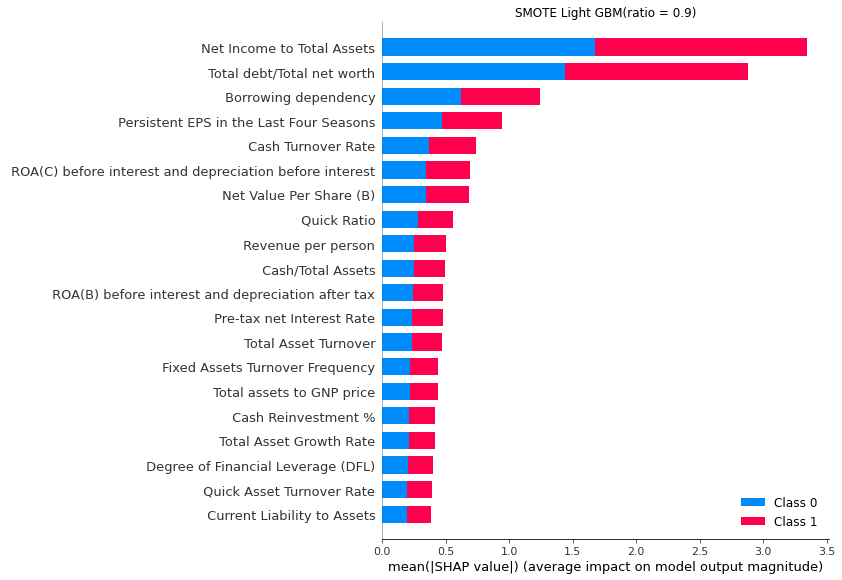

In [91]:
plt.title("SMOTE Light GBM(ratio = 0.9)")
explainer = shap.TreeExplainer(lgbm_smote_5)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

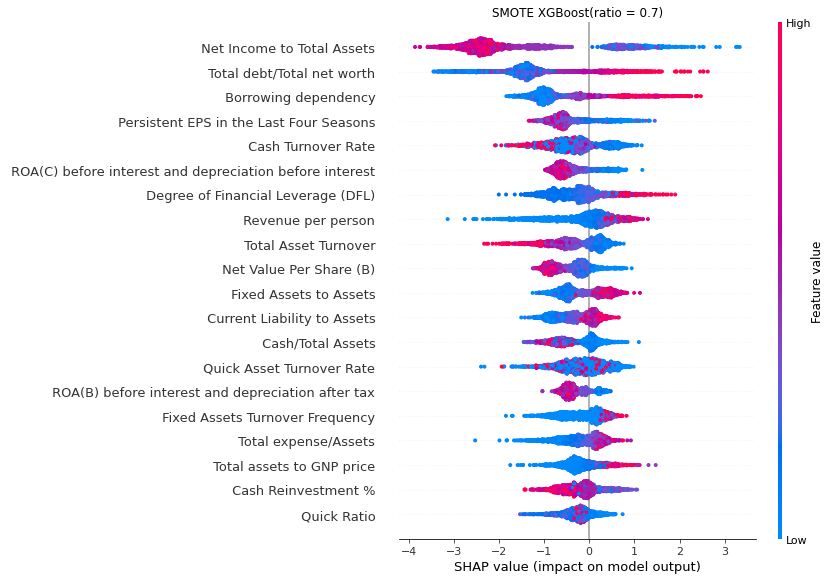

In [79]:
plt.title("SMOTE XGBoost(ratio = 0.7)")
explainer = shap.TreeExplainer(xgb_smote_1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

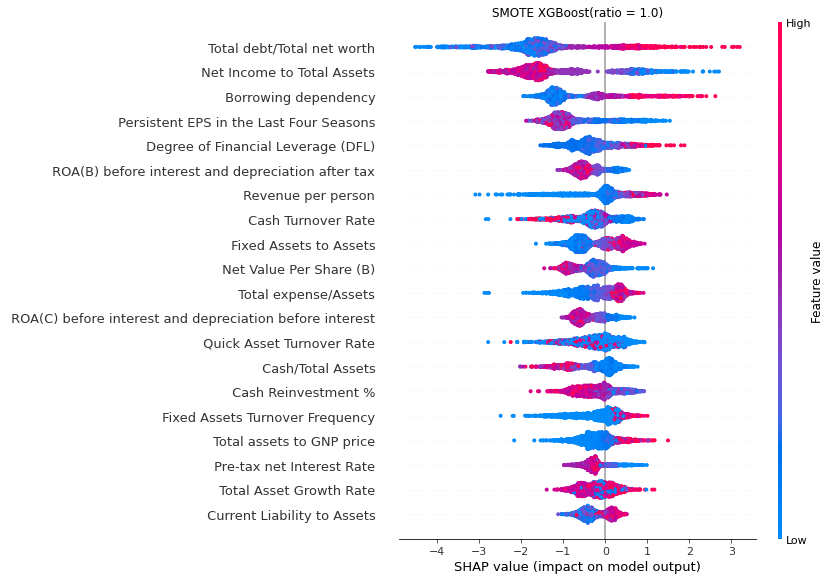

In [80]:
plt.title("SMOTE XGBoost(ratio = 1.0)")
explainer = shap.TreeExplainer(xgb_smote_7)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

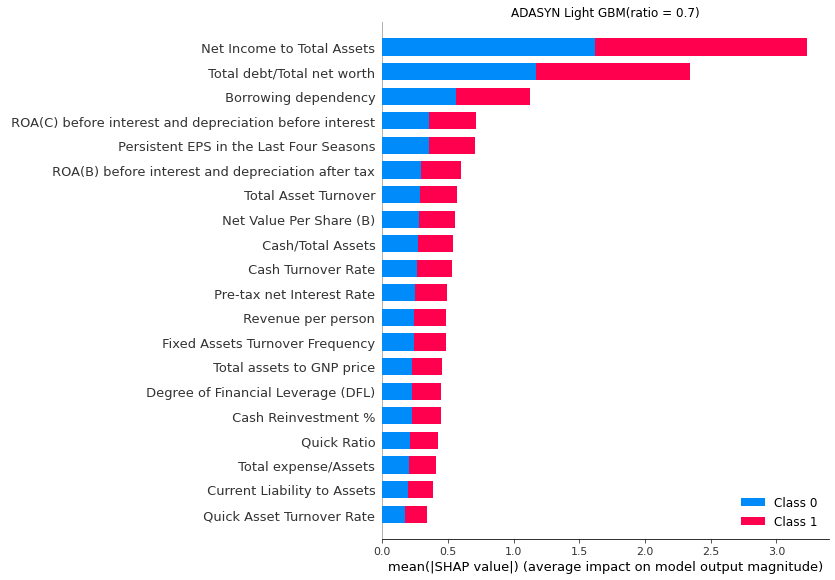

In [81]:
plt.title("ADASYN Light GBM(ratio = 0.7)")
explainer = shap.TreeExplainer(lgbm_ads1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

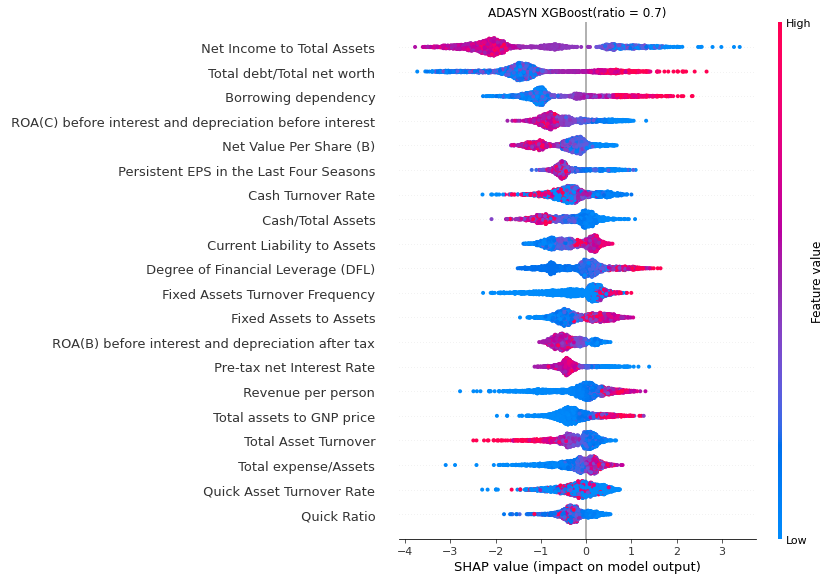

In [82]:
plt.title("ADASYN XGBoost(ratio = 0.7)")
explainer = shap.TreeExplainer(xgb_ads1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

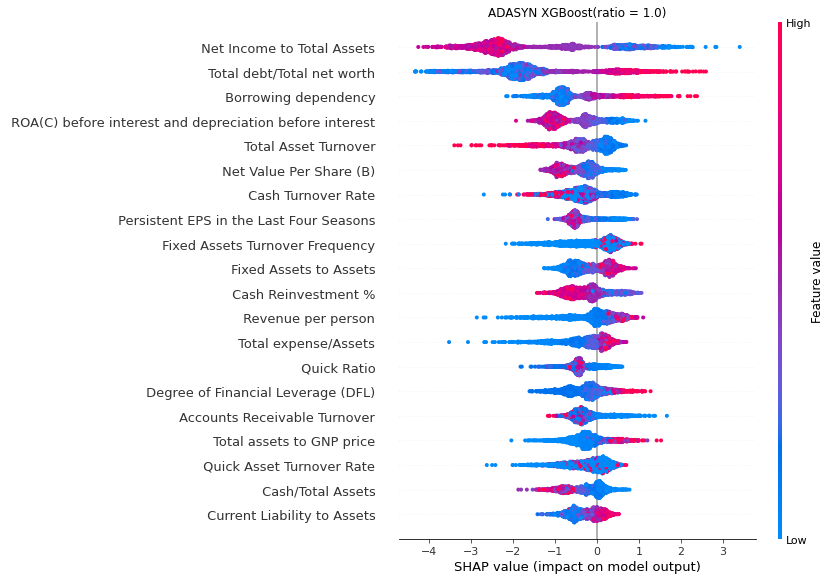

In [83]:
plt.title("ADASYN XGBoost(ratio = 1.0)")
explainer = shap.TreeExplainer(xgb_ads7)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

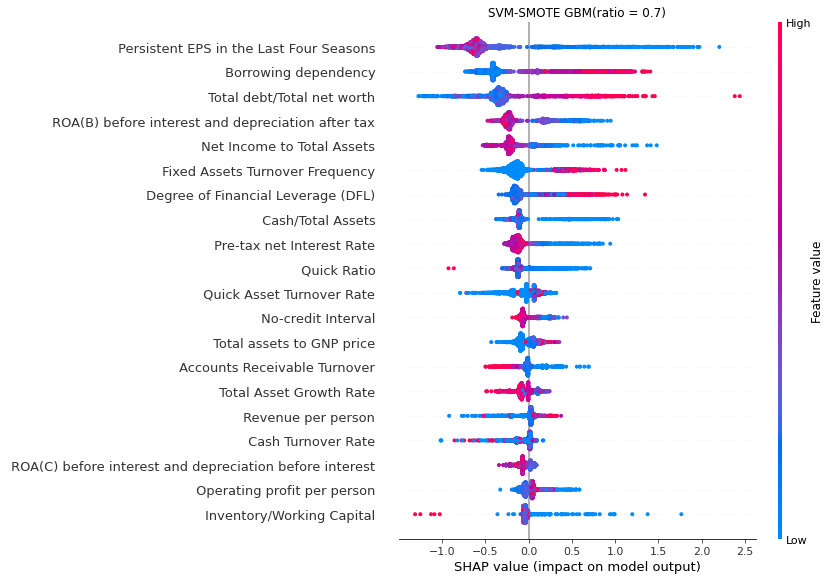

In [84]:
plt.title("SVM-SMOTE GBM(ratio = 0.7)")
explainer = shap.TreeExplainer(gbm_svm_smote1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

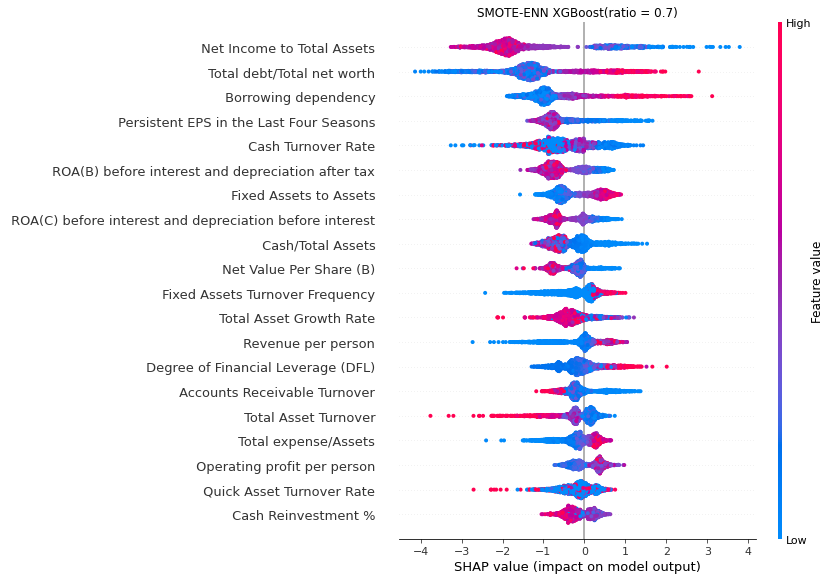

In [85]:
plt.title("SMOTE-ENN XGBoost(ratio = 0.7)")
explainer = shap.TreeExplainer(xgb_smote_enn1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

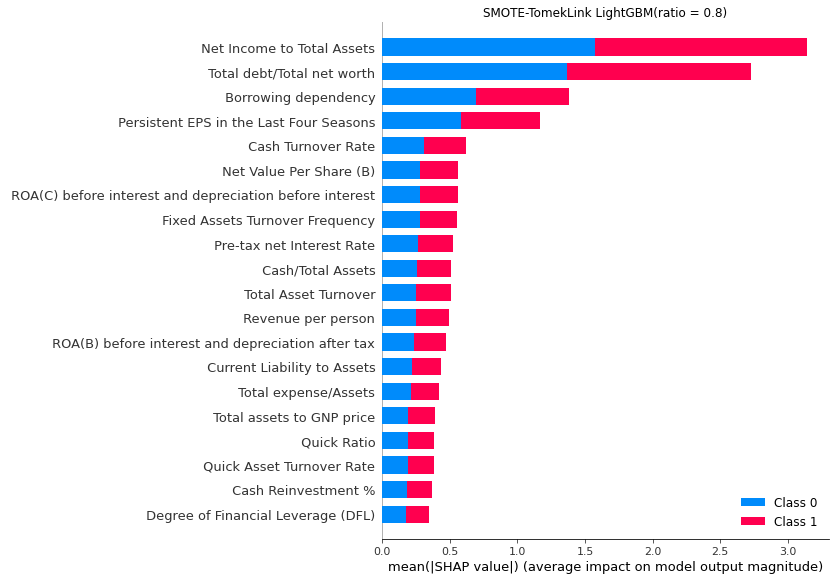

In [92]:
plt.title("SMOTE-TomekLink LightGBM(ratio = 0.8)")
explainer = shap.TreeExplainer(lgbm_smotetomek3)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

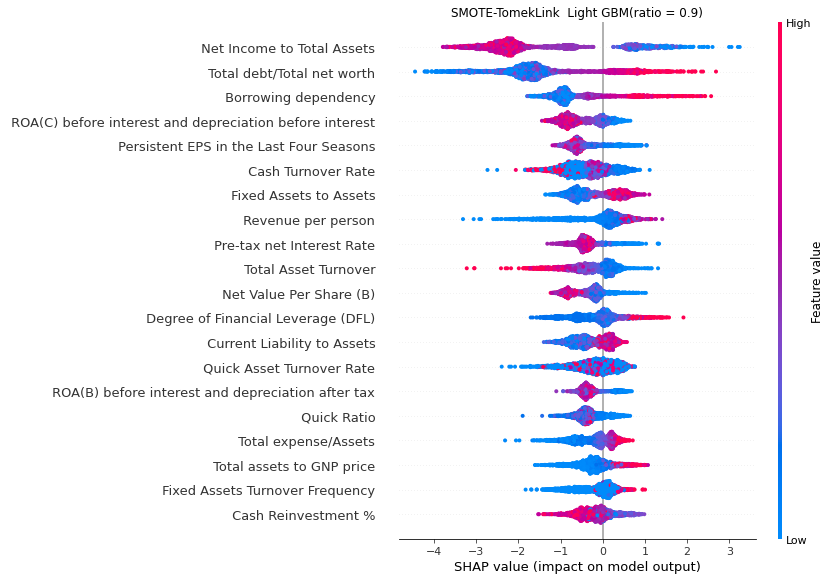

In [87]:
plt.title("SMOTE-TomekLink  XGBoost(ratio = 0.9)")
explainer = shap.TreeExplainer(xgb_smotetomek5)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()